# Looking at 3 Years of aTmCam Data: A Pandas Odyssey

* Authors:  Douglas Tucker, Sahar Allam, James Lasker, and Ting Li
* Version:  v3.0
* Date: 10 April 2017

***

## Acknowledgments

Thanks to Ting Li for providing and explaining the aTmCam data!

***

## Goals

* (Personal goal) Better understand aTmCam (and GPSmon) outputs.

* (Personal goal) Improve abilities with Python Pandas package.

* Estimate DECam u,g,r,i,z,Y first-order extinctions from atmCam mag1,mag2,mag3,mag4 observations directly via empirical fits (avoiding -- at least as much as possible! -- fits to atmospheric models).

* Help in calibrating DECam data outside the main DES footprint, especially data with limited number of overlapping exposures (e.g., BLISS) and/or in non-standard DES filters (e.g., u-band)

***

## Some Background

### atmCam:

* 4 cameras (one filter per camera), located near the CTIO-1.0m dome, that simultaneously observe a set of bright A0V stars over the course of the night.

* The wavelengths of the 4 aTmCam filters (see [DES-doc#8166](http://des-docdb.fnal.gov:8080/cgi-bin/ShowDocument?docid=8166 "DES-doc#8166")) are at 396, 520, 852, and 940 nm for mag1, mag2, mag3, and mag4, respectively.

![](aTmCamFilters.png)

### GPSmon:

* Uses dual-band GPS receiver on CTIO-1.5m dome to measure index of refraction of atmosphere  between the receiver and the network of GPS satellites.

***

## Preparations...

**I ran he following first, as a bash script, to grab all of the relevant aTmCam text files and plots for the binned 2x2 procesing from Ting's TAMU webpage:**

<pre>
cd /Users/dtucker/Desktop
mkdir Test2016
echo Test2016
cd Test2016
wget -r -np -nH --cut-dirs=2 -R index.html* http://instrumentation.tamu.edu/~ting/atmcam_summary_bin2

cd /Users/dtucker/Desktop
mkdir Test2015
echo Test2015
cd Test2015
wget -r -np -nH --cut-dirs=2 -R index.html* http://instrumentation.tamu.edu/~ting/atmcam_summary_bin2_2015

cd /Users/dtucker/Desktop
mkdir Test2014
echo Test2014
cd Test2014
wget -r -np -nH --cut-dirs=2 -R index.html* http://instrumentation.tamu.edu/~ting/atmcam_summary_bin2_2014
cd /Users/dtucker/Desktop

echo "Finis!"
</pre>



**Suominet GPS PWV results can be found on des20.fnal.gov in:  
/data/des20.b/data/SNDATA_ROOT/INTERNAL/DES/GPS/SuominetResults/SuominetResults.csv **


***


## Now, onto the analysis...

### Initial setup...

In [1]:
# Initial setup...
import numpy as np
import pandas as pd
from scipy import interpolate
import glob
import math
import matplotlib.pyplot as plt
from scipy.optimize import leastsq

%matplotlib inline

In [2]:
%pwd

u'/Users/dtucker/Desktop/aTmCam_analysis'

***
### Looking at a single night (2016-08-09)...

In [3]:
# The aTmCam observing log for the night of 2016-08-09:
obslog1 = 'aTmCam_data/Test2016/2457610-20160809/2457610-20160809_obs_log.txt'

# We just want the aTmCam exposure id and the exposure times in the 4 narrow-band filters:
obsdf1 = pd.read_csv(obslog1, usecols=['#expid', 'exptime1', 'exptime2', 'exptime3', 'exptime4'], delim_whitespace=True)

# Let's rename the column "#expid" to "expid":
obsdf1.rename(columns={'#expid': 'expid'}, inplace=True)

# Now let's look at our pandas DataFrame for this data set:
obsdf1

expid  exptime1  exptime2  exptime3  exptime4
0        1      15.0      15.0      15.0      15.0
1        2      15.0      15.0      15.0      15.0
2        3      15.0      15.0      15.0      15.0
3        4      15.0      15.0      15.0      15.0
4        5      15.0      15.0      15.0      15.0
5        6      15.0      15.0      15.0      15.0
6        7      15.0      15.0      15.0      15.0
7        8      15.0      15.0      15.0      15.0
8        9      15.0      15.0      15.0      15.0
9       10      15.0      15.0      15.0      15.0
10      11      15.0      15.0      15.0      15.0
11      12      15.0      15.0      15.0      15.0
12      13      15.0      15.0      15.0      15.0
13      14      15.0      15.0      15.0      15.0
14      15      15.0      15.0      15.0      15.0
15      16      15.0      15.0      15.0      15.0
16      17      15.0      15.0      15.0      15.0
17      18      15.0      15.0      15.0      15.0
18      19      15.0      15.0      15.0      15.0
19      20      15.0      15.0      15.0      15.0
20      21      15.0      15.0      15.0      15.0
21      22      15.0      15.0      15.0      15.0
22      23      15.0      15.0      15.0      15.0
23      24      30.0      30.0      30.0      30.0
24      25      30.0      30.0      30.0      30.0
25      26      30.0      30.0      30.0      30.0
26      27      30.0      30.0      30.0      30.0
27      28      30.0      30.0      30.0      30.0
28      29      30.0      30.0      30.0      30.0
29      30      30.0      30.0      30.0      30.0
..     ...       ...       ...       ...       ...
734    735      15.0      15.0      15.0      15.0
735    736      15.0      15.0      15.0      15.0
736    737      15.0      15.0      15.0      15.0
737    738      15.0      15.0      15.0      15.0
738    739      15.0      15.0      15.0      15.0
739    740      15.0      15.0      15.0      15.0
740    741      15.0      15.0      15.0      15.0
741    742      15.0      15.0      15.0      15.0
742    743      15.0      15.0      15.0      15.0
743    744      15.0      15.0      15.0      15.0
744    745      15.0      15.0      15.0      15.0
745    746      15.0      15.0      15.0      15.0
746    747      15.0      15.0      15.0      15.0
747    748      15.0      15.0      15.0      15.0
748    749      15.0      15.0      15.0      15.0
749    750      15.0      15.0      15.0      15.0
750    751      15.0      15.0      15.0      15.0
751    752      15.0      15.0      15.0      15.0
752    753      15.0      15.0      15.0      15.0
753    754      15.0      15.0      15.0      15.0
754    755      15.0      15.0      15.0      15.0
755    756      15.0      15.0      15.0      15.0
756    757      15.0      15.0      15.0      15.0
757    758      15.0      15.0      15.0      15.0
758    759      15.0      15.0      15.0      15.0
759    760      15.0      15.0      15.0      15.0
760    761      15.0      15.0      15.0      15.0
761    762      15.0      15.0      15.0      15.0
762    763      15.0      15.0      15.0      15.0
763    764      15.0      15.0      15.0      15.0

[764 rows x 5 columns]

In [4]:
# The aTmCam instrumental magnitude file for the night of 2016-08-09:
maglog1 = 'aTmCam_data/Test2016/2457610-20160809/2457610-20160809_final_data.txt'

# We'll read in all the columns...
magdf1 = pd.read_csv(maglog1, delim_whitespace=True)

# But, as with the observing log, let's rename the column "#expid" to "expid":
magdf1.rename(columns={'#expid': 'expid'}, inplace=True)

# Now let's look at our pandas DataFrame for this data set:
magdf1

expid                 date-obs          mjd     object        obj_ra  \
0      191  2016-08-10T01:50:43.000  57610.07689   HIP75501  15:26:25.372   
1      192  2016-08-10T01:51:29.000  57610.07742   HIP75501  15:26:25.372   
2      193  2016-08-10T01:52:16.000  57610.07796   HIP75501  15:26:25.372   
3      194  2016-08-10T01:53:02.000  57610.07850   HIP75501  15:26:25.372   
4      195  2016-08-10T01:53:48.000  57610.07903   HIP75501  15:26:25.372   
5      196  2016-08-10T01:54:34.000  57610.07956   HIP75501  15:26:25.372   
6      197  2016-08-10T01:55:21.000  57610.08010   HIP75501  15:26:25.372   
7      198  2016-08-10T01:56:07.000  57610.08064   HIP75501  15:26:25.372   
8      199  2016-08-10T01:56:53.000  57610.08117   HIP75501  15:26:25.372   
9      200  2016-08-10T01:57:39.000  57610.08170   HIP75501  15:26:25.372   
10     201  2016-08-10T01:58:25.000  57610.08223   HIP75501  15:26:25.372   
11     202  2016-08-10T01:59:12.000  57610.08278   HIP75501  15:26:25.372   
12     203  2016-08-10T01:59:58.000  57610.08331   HIP75501  15:26:25.372   
13     204  2016-08-10T02:00:44.000  57610.08384   HIP75501  15:26:25.372   
14     205  2016-08-10T02:01:30.000  57610.08437   HIP75501  15:26:25.372   
15     206  2016-08-10T02:02:17.000  57610.08492   HIP75501  15:26:25.372   
16     207  2016-08-10T02:03:03.000  57610.08545   HIP75501  15:26:25.372   
17     208  2016-08-10T02:03:49.000  57610.08598   HIP75501  15:26:25.372   
18     209  2016-08-10T02:04:35.000  57610.08652   HIP75501  15:26:25.372   
19     210  2016-08-10T02:05:21.000  57610.08705   HIP75501  15:26:25.372   
20     211  2016-08-10T02:06:08.000  57610.08759   HIP75501  15:26:25.372   
21     212  2016-08-10T02:06:54.000  57610.08813   HIP75501  15:26:25.372   
22     213  2016-08-10T02:07:40.000  57610.08866   HIP75501  15:26:25.372   
23     214  2016-08-10T02:10:43.000  57610.09078   HIP98495  20:02:31.508   
24     215  2016-08-10T02:11:24.000  57610.09125   HIP98495  20:02:31.508   
25     216  2016-08-10T02:12:06.000  57610.09174   HIP98495  20:02:31.508   
26     217  2016-08-10T02:12:47.000  57610.09221   HIP98495  20:02:31.508   
27     218  2016-08-10T02:13:28.000  57610.09269   HIP98495  20:02:31.508   
28     219  2016-08-10T02:14:09.000  57610.09316   HIP98495  20:02:31.508   
29     220  2016-08-10T02:14:51.000  57610.09365   HIP98495  20:02:31.508   
..     ...                      ...          ...        ...           ...   
469    689  2016-08-10T09:36:53.000  57610.40061  HIP117452  23:49:47.711   
470    690  2016-08-10T09:37:39.000  57610.40115  HIP117452  23:49:47.711   
471    691  2016-08-10T09:40:43.000  57610.40328   HIP11345  02:26:45.099   
472    692  2016-08-10T09:41:29.000  57610.40381   HIP11345  02:26:45.099   
473    693  2016-08-10T09:42:15.000  57610.40434   HIP11345  02:26:45.099   
474    694  2016-08-10T09:43:01.000  57610.40487   HIP11345  02:26:45.099   
475    695  2016-08-10T09:43:47.000  57610.40541   HIP11345  02:26:45.099   
476    696  2016-08-10T09:44:34.000  57610.40595   HIP11345  02:26:45.099   
477    697  2016-08-10T09:45:20.000  57610.40648   HIP11345  02:26:45.099   
478    698  2016-08-10T09:46:06.000  57610.40701   HIP11345  02:26:45.099   
479    699  2016-08-10T09:46:52.000  57610.40755   HIP11345  02:26:45.099   
480    700  2016-08-10T09:47:38.000  57610.40808   HIP11345  02:26:45.099   
481    701  2016-08-10T09:50:43.000  57610.41022  HIP117452  23:49:47.718   
482    702  2016-08-10T09:51:29.000  57610.41075  HIP117452  23:49:47.718   
483    703  2016-08-10T09:52:15.000  57610.41128  HIP117452  23:49:47.718   
484    704  2016-08-10T09:53:01.000  57610.41182  HIP117452  23:49:47.718   
485    705  2016-08-10T09:53:47.000  57610.41235  HIP117452  23:49:47.718   
486    706  2016-08-10T09:54:34.000  57610.41289  HIP117452  23:49:47.718   
487    707  2016-08-10T09:55:20.000  57610.41343  HIP117452  23:49:47.718   
488    708  2016-08-10T09:56:06.000  57610.41396  HIP117452  23:49:47.718   
4

In [5]:
# List all the columns loaded into the instrumental magnitude DataFrame:
magdf1.columns

Index([u'expid', u'date-obs', u'mjd', u'object', u'obj_ra', u'obj_dec',
       u'airmass', u'mag1', u'mag2', u'mag3', u'mag4', u'magerr1', u'magerr2',
       u'magerr3', u'magerr4', u'fwhm1', u'fwhm2', u'fwhm3', u'fwhm4',
       u'pos_x1', u'pos_x2', u'pos_x3', u'pos_x4', u'pos_y1', u'pos_y2',
       u'pos_y3', u'pos_y4'],
      dtype='object')

In [6]:
# Perform an "inner join" on the expid column for the instrumental magnitude DataFrame 
# and the observing log DataFrame for this night (2016-08-09):
#magobsdf1 = pd.merge(magdf1, obsdf1, on=['expid', 'expid'], how='inner')
magobsdf1 = pd.merge(magdf1, obsdf1, on='expid', how='inner')
magobsdf1

expid                 date-obs          mjd     object        obj_ra  \
0      191  2016-08-10T01:50:43.000  57610.07689   HIP75501  15:26:25.372   
1      192  2016-08-10T01:51:29.000  57610.07742   HIP75501  15:26:25.372   
2      193  2016-08-10T01:52:16.000  57610.07796   HIP75501  15:26:25.372   
3      194  2016-08-10T01:53:02.000  57610.07850   HIP75501  15:26:25.372   
4      195  2016-08-10T01:53:48.000  57610.07903   HIP75501  15:26:25.372   
5      196  2016-08-10T01:54:34.000  57610.07956   HIP75501  15:26:25.372   
6      197  2016-08-10T01:55:21.000  57610.08010   HIP75501  15:26:25.372   
7      198  2016-08-10T01:56:07.000  57610.08064   HIP75501  15:26:25.372   
8      199  2016-08-10T01:56:53.000  57610.08117   HIP75501  15:26:25.372   
9      200  2016-08-10T01:57:39.000  57610.08170   HIP75501  15:26:25.372   
10     201  2016-08-10T01:58:25.000  57610.08223   HIP75501  15:26:25.372   
11     202  2016-08-10T01:59:12.000  57610.08278   HIP75501  15:26:25.372   
12     203  2016-08-10T01:59:58.000  57610.08331   HIP75501  15:26:25.372   
13     204  2016-08-10T02:00:44.000  57610.08384   HIP75501  15:26:25.372   
14     205  2016-08-10T02:01:30.000  57610.08437   HIP75501  15:26:25.372   
15     206  2016-08-10T02:02:17.000  57610.08492   HIP75501  15:26:25.372   
16     207  2016-08-10T02:03:03.000  57610.08545   HIP75501  15:26:25.372   
17     208  2016-08-10T02:03:49.000  57610.08598   HIP75501  15:26:25.372   
18     209  2016-08-10T02:04:35.000  57610.08652   HIP75501  15:26:25.372   
19     210  2016-08-10T02:05:21.000  57610.08705   HIP75501  15:26:25.372   
20     211  2016-08-10T02:06:08.000  57610.08759   HIP75501  15:26:25.372   
21     212  2016-08-10T02:06:54.000  57610.08813   HIP75501  15:26:25.372   
22     213  2016-08-10T02:07:40.000  57610.08866   HIP75501  15:26:25.372   
23     214  2016-08-10T02:10:43.000  57610.09078   HIP98495  20:02:31.508   
24     215  2016-08-10T02:11:24.000  57610.09125   HIP98495  20:02:31.508   
25     216  2016-08-10T02:12:06.000  57610.09174   HIP98495  20:02:31.508   
26     217  2016-08-10T02:12:47.000  57610.09221   HIP98495  20:02:31.508   
27     218  2016-08-10T02:13:28.000  57610.09269   HIP98495  20:02:31.508   
28     219  2016-08-10T02:14:09.000  57610.09316   HIP98495  20:02:31.508   
29     220  2016-08-10T02:14:51.000  57610.09365   HIP98495  20:02:31.508   
..     ...                      ...          ...        ...           ...   
469    689  2016-08-10T09:36:53.000  57610.40061  HIP117452  23:49:47.711   
470    690  2016-08-10T09:37:39.000  57610.40115  HIP117452  23:49:47.711   
471    691  2016-08-10T09:40:43.000  57610.40328   HIP11345  02:26:45.099   
472    692  2016-08-10T09:41:29.000  57610.40381   HIP11345  02:26:45.099   
473    693  2016-08-10T09:42:15.000  57610.40434   HIP11345  02:26:45.099   
474    694  2016-08-10T09:43:01.000  57610.40487   HIP11345  02:26:45.099   
475    695  2016-08-10T09:43:47.000  57610.40541   HIP11345  02:26:45.099   
476    696  2016-08-10T09:44:34.000  57610.40595   HIP11345  02:26:45.099   
477    697  2016-08-10T09:45:20.000  57610.40648   HIP11345  02:26:45.099   
478    698  2016-08-10T09:46:06.000  57610.40701   HIP11345  02:26:45.099   
479    699  2016-08-10T09:46:52.000  57610.40755   HIP11345  02:26:45.099   
480    700  2016-08-10T09:47:38.000  57610.40808   HIP11345  02:26:45.099   
481    701  2016-08-10T09:50:43.000  57610.41022  HIP117452  23:49:47.718   
482    702  2016-08-10T09:51:29.000  57610.41075  HIP117452  23:49:47.718   
483    703  2016-08-10T09:52:15.000  57610.41128  HIP117452  23:49:47.718   
484    704  2016-08-10T09:53:01.000  57610.41182  HIP117452  23:49:47.718   
485    705  2016-08-10T09:53:47.000  57610.41235  HIP117452  23:49:47.718   
486    706  2016-08-10T09:54:34.000  57610.41289  HIP117452  23:49:47.718   
487    707  2016-08-10T09:55:20.000  57610.41343  HIP117452  23:49:47.718   
488    708  2016-08-10T09:56:06.000  57610.41396  HIP117452  23:49:47.718   
4

In [7]:
# List all the columns in the merged DataFrame:
magobsdf1.columns

Index([u'expid', u'date-obs', u'mjd', u'object', u'obj_ra', u'obj_dec',
       u'airmass', u'mag1', u'mag2', u'mag3', u'mag4', u'magerr1', u'magerr2',
       u'magerr3', u'magerr4', u'fwhm1', u'fwhm2', u'fwhm3', u'fwhm4',
       u'pos_x1', u'pos_x2', u'pos_x3', u'pos_x4', u'pos_y1', u'pos_y2',
       u'pos_y3', u'pos_y4', u'exptime1', u'exptime2', u'exptime3',
       u'exptime4'],
      dtype='object')

In [8]:
# Print the first 3 lines of the merged DataFrame:
print magobsdf1[:3]

   expid                 date-obs          mjd    object        obj_ra  \
0    191  2016-08-10T01:50:43.000  57610.07689  HIP75501  15:26:25.372   
1    192  2016-08-10T01:51:29.000  57610.07742  HIP75501  15:26:25.372   
2    193  2016-08-10T01:52:16.000  57610.07796  HIP75501  15:26:25.372   

         obj_dec  airmass     mag1     mag2     mag3    ...      pos_x3  \
0  -38:47:27.835   1.2532  14.4496  14.0773  16.0983    ...     496.804   
1  -38:47:27.835   1.2557  14.4587  14.0667  16.0736    ...     496.940   
2  -38:47:27.835   1.2582  14.4498  14.0661  16.0721    ...     497.105   

    pos_x4   pos_y1   pos_y2   pos_y3   pos_y4  exptime1  exptime2  exptime3  \
0  465.194  505.056  539.189  583.625  585.716      15.0      15.0      15.0   
1  465.307  505.296  539.520  584.043  586.038      15.0      15.0      15.0   
2  465.426  505.465  539.672  584.023  586.115      15.0      15.0      15.0   

   exptime4  
0      15.0  
1      15.0  
2      15.0  

[3 rows x 31 columns]


In [9]:
# Same as above, but "prettier":
magobsdf1.head(3)

expid                 date-obs          mjd    object        obj_ra  \
0    191  2016-08-10T01:50:43.000  57610.07689  HIP75501  15:26:25.372   
1    192  2016-08-10T01:51:29.000  57610.07742  HIP75501  15:26:25.372   
2    193  2016-08-10T01:52:16.000  57610.07796  HIP75501  15:26:25.372   

         obj_dec  airmass     mag1     mag2     mag3    ...      pos_x3  \
0  -38:47:27.835   1.2532  14.4496  14.0773  16.0983    ...     496.804   
1  -38:47:27.835   1.2557  14.4587  14.0667  16.0736    ...     496.940   
2  -38:47:27.835   1.2582  14.4498  14.0661  16.0721    ...     497.105   

    pos_x4   pos_y1   pos_y2   pos_y3   pos_y4  exptime1  exptime2  exptime3  \
0  465.194  505.056  539.189  583.625  585.716      15.0      15.0      15.0   
1  465.307  505.296  539.520  584.043  586.038      15.0      15.0      15.0   
2  465.426  505.465  539.672  584.023  586.115      15.0      15.0      15.0   

   exptime4  
0      15.0  
1      15.0  
2      15.0  

[3 rows x 31 columns]

In [10]:
# Start a matplotlib figure:
plt.figure()

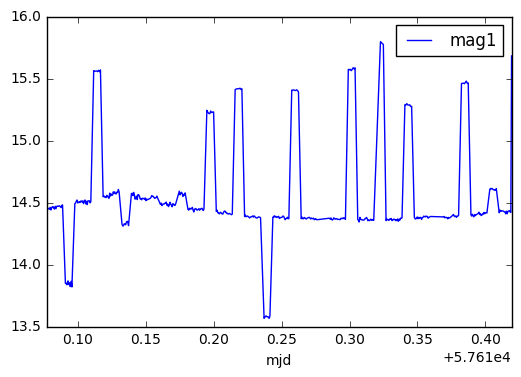

In [11]:
# Plot mag1 vs. MJD for the night...
# Note that these are instrumental mags of multiple Hipparcos stars taken during the night...
magobsdf1.plot('mjd','mag1')

In [12]:
# Output a list of unique star names observed on this night...
magobsdf1['object'].unique()

array(['HIP75501', 'HIP98495', 'HIP114132', 'HIP86092', 'HIP117452',
       'HIP93148', 'HIP6960', 'HIP102633', 'HIP110395', 'HIP110578',
       'HIP25608', 'HIP20264', 'HIP11345'], dtype=object)

In [13]:
# We can also run the previous command this way:
magobsdf1.object.unique()

array(['HIP75501', 'HIP98495', 'HIP114132', 'HIP86092', 'HIP117452',
       'HIP93148', 'HIP6960', 'HIP102633', 'HIP110395', 'HIP110578',
       'HIP25608', 'HIP20264', 'HIP11345'], dtype=object)

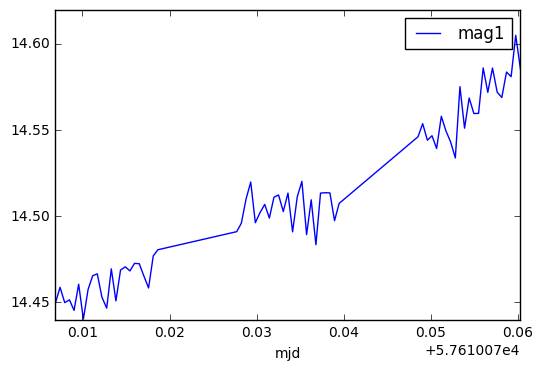

In [14]:
# Let's only plot observations for Hipparcos star 'HIP75501'...
#  Its insturmental magnitude is increasing because it is being observed at 
#  steadily increasing airmass...
magobsdf1[(magobsdf1.object=='HIP75501')].plot('mjd','mag1')

In [15]:
#What is the frequency distribution of observations of the stars observed on this night?
magobsdf1['object'].value_counts()

HIP117452    314
HIP75501      69
HIP114132     22
HIP93148      19
HIP98495      11
HIP86092      10
HIP110395     10
HIP11345      10
HIP6960        8
HIP20264       8
HIP102633      8
HIP110578      8
HIP25608       2
Name: object, dtype: int64

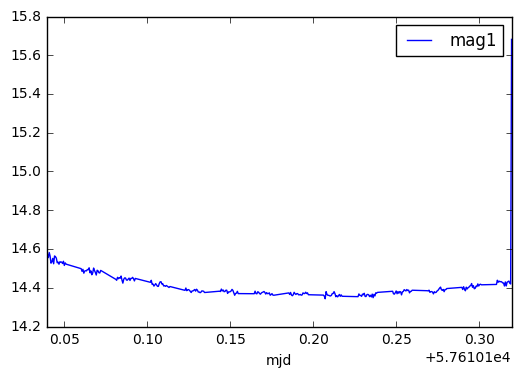

In [16]:
# 'HIP117452' was observed the most (314 times); let's plot it...
#  Note the gradual change in instrumental mag for this star as aTmCam follows it over the 
#  course of the night.
magobsdf1[(magobsdf1.object=='HIP117452')].plot('mjd','mag1')

***
### Looking at all the nights...

In [17]:
# Let's grab all the observing logs for all three 3 years into a single sorted list...
obsLogList = sorted(glob.glob('aTmCam_data/Test201?/???????-????????/???????-????????_obs_log.txt'))
obsLogList

['aTmCam_data/Test2014/2456900-20140830/2456900-20140830_obs_log.txt',
 'aTmCam_data/Test2014/2456901-20140831/2456901-20140831_obs_log.txt',
 'aTmCam_data/Test2014/2456902-20140901/2456902-20140901_obs_log.txt',
 'aTmCam_data/Test2014/2456903-20140902/2456903-20140902_obs_log.txt',
 'aTmCam_data/Test2014/2456904-20140903/2456904-20140903_obs_log.txt',
 'aTmCam_data/Test2014/2456905-20140904/2456905-20140904_obs_log.txt',
 'aTmCam_data/Test2014/2456906-20140905/2456906-20140905_obs_log.txt',
 'aTmCam_data/Test2014/2456907-20140906/2456907-20140906_obs_log.txt',
 'aTmCam_data/Test2014/2456908-20140907/2456908-20140907_obs_log.txt',
 'aTmCam_data/Test2014/2456909-20140908/2456909-20140908_obs_log.txt',
 'aTmCam_data/Test2014/2456910-20140909/2456910-20140909_obs_log.txt',
 'aTmCam_data/Test2014/2456911-20140910/2456911-20140910_obs_log.txt',
 'aTmCam_data/Test2014/2456915-20140914/2456915-20140914_obs_log.txt',
 'aTmCam_data/Test2014/2456916-20140915/2456916-20140915_obs_log.txt',
 'aTmC

In [18]:
# Now load all the observing logs from the 3 years into a single pandas DataFrame...
# (Sahar pointed me to this nifty trick from Stackoverflow:
#  http://stackoverflow.com/questions/20906474/import-multiple-csv-files-into-pandas-and-concatenate-into-one-dataframe)
obsdf_from_each_file = (pd.read_csv(obslog, usecols=['date-obs', 'mjd', '#expid', 'exptime1', 'exptime2', 'exptime3', 'exptime4'], delim_whitespace=True) for obslog in obsLogList)
obsdf = pd.concat(obsdf_from_each_file, ignore_index=True)

# NOTE:  WE LATER DISCOVERED THAT OBSDF CONTAINED LOTS OF DUPLICATE ROWS!
#        THEREFORE, WE USE THE PANDAS DROP_DUPLICATES() FUNCTION TO REMOVE THESE HERE.

obsdf.drop_duplicates(inplace=True)

# We will also take the opportunity to sort by MJD here...
obsdf.sort_values(by='mjd', inplace=True)

# And print out first 10 rows...
obsdf.head(10)

#expid                 date-obs          mjd  exptime1  exptime2  exptime3  \
0     1.0  2014-08-31T00:53:16.000  56900.03699      30.0      30.0      30.0   
1     2.0  2014-08-31T00:56:25.000  56900.03918      30.0      30.0      30.0   
2     3.0  2014-08-31T00:57:50.000  56900.04016       1.0       1.0       1.0   
3     4.0  2014-08-31T00:58:26.000  56900.04058       1.0       1.0       1.0   
4     5.0  2014-08-31T00:59:01.000  56900.04098       1.0       1.0       1.0   
5     6.0  2014-08-31T00:59:36.000  56900.04139       1.0       1.0       1.0   
6     7.0  2014-08-31T01:00:38.000  56900.04211     120.0     120.0     120.0   
7     8.0  2014-08-31T01:03:11.000  56900.04388     120.0     120.0     120.0   
8     9.0  2014-08-31T01:06:25.000  56900.04612     300.0     300.0     500.0   
9    10.0  2014-08-31T01:18:48.000  56900.05472     300.0     300.0     900.0   

   exptime4  
0      30.0  
1      30.0  
2       1.0  
3       1.0  
4       1.0  
5       1.0  
6     120.0  
7     120.0  
8     500.0  
9     900.0

In [19]:
# Let's add columns for an integer MJD and for UT [hours]...
#  (Stole this idea from how we did this in SDSS!:)
obsdf['imjd'] = np.floor(obsdf['mjd']+0.3).astype(int)
obsdf['UT_hour'] = 24.*(obsdf['mjd'] - obsdf['imjd'])

# And, as before, let's rename column "#expid" to "expid"...
obsdf.rename(columns={'#expid': 'expid'}, inplace=True)

# Oops... somehow, expid became a "float"...  let's re-cast it back to an "int"...
obsdf.expid = obsdf.expid.astype(int)

# And print out the first 10 rows...
obsdf.head(10)

expid                 date-obs          mjd  exptime1  exptime2  exptime3  \
0      1  2014-08-31T00:53:16.000  56900.03699      30.0      30.0      30.0   
1      2  2014-08-31T00:56:25.000  56900.03918      30.0      30.0      30.0   
2      3  2014-08-31T00:57:50.000  56900.04016       1.0       1.0       1.0   
3      4  2014-08-31T00:58:26.000  56900.04058       1.0       1.0       1.0   
4      5  2014-08-31T00:59:01.000  56900.04098       1.0       1.0       1.0   
5      6  2014-08-31T00:59:36.000  56900.04139       1.0       1.0       1.0   
6      7  2014-08-31T01:00:38.000  56900.04211     120.0     120.0     120.0   
7      8  2014-08-31T01:03:11.000  56900.04388     120.0     120.0     120.0   
8      9  2014-08-31T01:06:25.000  56900.04612     300.0     300.0     500.0   
9     10  2014-08-31T01:18:48.000  56900.05472     300.0     300.0     900.0   

   exptime4   imjd  UT_hour  
0      30.0  56900  0.88776  
1      30.0  56900  0.94032  
2       1.0  56900  0.96384  
3       1.0  56900  0.97392  
4       1.0  56900  0.98352  
5       1.0  56900  0.99336  
6     120.0  56900  1.01064  
7     120.0  56900  1.05312  
8     500.0  56900  1.10688  
9     900.0  56900  1.31328

In [20]:
# Let's now grab all the instrumental magnitude files for all three 3 years into a single 
#  sorted list...
magLogList = sorted(glob.glob('aTmCam_data/Test201?/???????-????????/???????-????????_final_data_bin2.txt'))

# How many of 'em are there?
len(magLogList)

720

In [21]:
# Now load all the instrumental magnitude files from the 3 years into a single pandas DataFrame...
# (Sahar pointed me to this nifty trick from Stackoverflow:
#  http://stackoverflow.com/questions/20906474/import-multiple-csv-files-into-pandas-and-concatenate-into-one-dataframe)
magdf_from_each_file = (pd.read_csv(maglog, delim_whitespace=True) for maglog in magLogList)
magdf = pd.concat(magdf_from_each_file, ignore_index=True)

# And print out first 10 rows...
magdf.head(10)

#expid                 date-obs          mjd     object        obj_ra  \
0   237.0  2014-09-01T05:05:50.000  56901.21238  HIP117452  23:49:42.610   
1   242.0  2014-09-01T05:09:28.000  56901.21491  HIP117452  23:49:42.610   
2   257.0  2014-09-01T05:27:54.000  56901.22771  HIP117452  23:49:42.610   
3   258.0  2014-09-01T05:28:38.000  56901.22822  HIP117452  23:49:42.610   
4   279.0  2014-09-01T05:54:29.000  56901.24617  HIP105140  21:18:51.001   
5   284.0  2014-09-01T05:58:07.000  56901.24869  HIP105140  21:18:51.001   
6   285.0  2014-09-01T05:58:51.000  56901.24920  HIP105140  21:18:51.001   
7   289.0  2014-09-01T06:04:49.000  56901.25334  HIP110578  22:24:54.299   
8   284.0  2014-09-02T03:52:02.000  56902.16113  HIP117452  23:49:42.623   
9   286.0  2014-09-02T03:54:53.000  56902.16311  HIP117452  23:49:42.623   

         obj_dec  airmass     mag1     mag2     mag3   ...     fwhm3  fwhm4  \
0  -28:02:42.563   1.0163  14.9742  14.7739  16.8629   ...     2.718  2.234   
1  -28:02:42.563   1.0139  14.5875  14.4159  16.5093   ...     2.752  2.056   
2  -28:02:42.563   1.0049  14.8078  14.5752  16.7427   ...     2.644  5.046   
3  -28:02:42.563   1.0046  14.9070  14.7155  16.7495   ...     2.838  3.186   
4  -32:06:26.609   1.1897  15.1957  14.8990  16.8779   ...     2.786  2.694   
5  -32:06:26.609   1.2001  14.6956  14.3202  16.3068   ...     2.868  2.190   
6  -32:06:26.609   1.2023  14.9313  14.5296  16.5423   ...     2.648  2.078   
7  -04:45:31.103   1.2287  16.5218  16.3684  18.6170   ...     2.488  2.292   
8  -28:02:42.618   1.1068  16.8462  16.5588  18.7460   ...     2.860  4.006   
9  -28:02:42.618   1.1012  16.5383  16.3203  18.0426   ...     2.896  2.316   

    pos_x1   pos_x2   pos_x3    pos_x4   pos_y1   pos_y2   pos_y3   pos_y4  
0  512.100  766.498  649.968   616.134  338.430  370.562  418.668  429.122  
1  512.900  767.228  650.124   616.400  336.544  369.076  418.410  429.340  
2  514.484  769.454  650.248   639.278  330.250  361.854  417.524  311.440  
3  513.808  769.804  650.054  1081.526  329.442  361.682  417.378  163.206  
4  505.716  765.316  645.034   594.766  376.346  403.902  456.314  316.288  
5  505.676  765.188  645.228   600.432  376.780  404.190  456.970  455.854  
6  505.762  765.382  645.452   600.632  376.904  404.386  456.880  455.924  
7  504.958  763.542  647.244  1167.618  363.360  386.674  447.480  492.004  
8  499.994  760.728  651.872   107.952  370.846  405.674  448.686  240.236  
9  500.032  760.690  651.608   617.678  370.516  405.158  448.100  448.484  

[10 rows x 27 columns]

In [22]:
# Let's add a column for an integer MJD...
magdf['imjd'] = np.floor(magdf['mjd']+0.3).astype(int)

# And, as before, let's rename column "#expid" to "expid"...
magdf.rename(columns={'#expid': 'expid'}, inplace=True)

# Again, we need to re-cast expid from a "float" back to an "int"...
magdf.expid = magdf.expid.astype(int)

# And print out first 10 rows...
magdf.head(10)

expid                 date-obs          mjd     object        obj_ra  \
0    237  2014-09-01T05:05:50.000  56901.21238  HIP117452  23:49:42.610   
1    242  2014-09-01T05:09:28.000  56901.21491  HIP117452  23:49:42.610   
2    257  2014-09-01T05:27:54.000  56901.22771  HIP117452  23:49:42.610   
3    258  2014-09-01T05:28:38.000  56901.22822  HIP117452  23:49:42.610   
4    279  2014-09-01T05:54:29.000  56901.24617  HIP105140  21:18:51.001   
5    284  2014-09-01T05:58:07.000  56901.24869  HIP105140  21:18:51.001   
6    285  2014-09-01T05:58:51.000  56901.24920  HIP105140  21:18:51.001   
7    289  2014-09-01T06:04:49.000  56901.25334  HIP110578  22:24:54.299   
8    284  2014-09-02T03:52:02.000  56902.16113  HIP117452  23:49:42.623   
9    286  2014-09-02T03:54:53.000  56902.16311  HIP117452  23:49:42.623   

         obj_dec  airmass     mag1     mag2     mag3  ...    fwhm4   pos_x1  \
0  -28:02:42.563   1.0163  14.9742  14.7739  16.8629  ...    2.234  512.100   
1  -28:02:42.563   1.0139  14.5875  14.4159  16.5093  ...    2.056  512.900   
2  -28:02:42.563   1.0049  14.8078  14.5752  16.7427  ...    5.046  514.484   
3  -28:02:42.563   1.0046  14.9070  14.7155  16.7495  ...    3.186  513.808   
4  -32:06:26.609   1.1897  15.1957  14.8990  16.8779  ...    2.694  505.716   
5  -32:06:26.609   1.2001  14.6956  14.3202  16.3068  ...    2.190  505.676   
6  -32:06:26.609   1.2023  14.9313  14.5296  16.5423  ...    2.078  505.762   
7  -04:45:31.103   1.2287  16.5218  16.3684  18.6170  ...    2.292  504.958   
8  -28:02:42.618   1.1068  16.8462  16.5588  18.7460  ...    4.006  499.994   
9  -28:02:42.618   1.1012  16.5383  16.3203  18.0426  ...    2.316  500.032   

    pos_x2   pos_x3    pos_x4   pos_y1   pos_y2   pos_y3   pos_y4   imjd  
0  766.498  649.968   616.134  338.430  370.562  418.668  429.122  56901  
1  767.228  650.124   616.400  336.544  369.076  418.410  429.340  56901  
2  769.454  650.248   639.278  330.250  361.854  417.524  311.440  56901  
3  769.804  650.054  1081.526  329.442  361.682  417.378  163.206  56901  
4  765.316  645.034   594.766  376.346  403.902  456.314  316.288  56901  
5  765.188  645.228   600.432  376.780  404.190  456.970  455.854  56901  
6  765.382  645.452   600.632  376.904  404.386  456.880  455.924  56901  
7  763.542  647.244  1167.618  363.360  386.674  447.480  492.004  56901  
8  760.728  651.872   107.952  370.846  405.674  448.686  240.236  56902  
9  760.690  651.608   617.678  370.516  405.158  448.100  448.484  56902  

[10 rows x 28 columns]

In [23]:
# Now to merge the two mega-DataFrames...
# Since the expids get reset each night, we need to match on both night *and* expid.
#  (For "night", we will use the integer MJD, "imjd")...

# We will use the suffix '_yyy' to indicate duplicate columns to drop later...
magobsdf = pd.merge(magdf, obsdf, on=['imjd','expid'], how='inner', suffixes=('', '_yyy'))
magobsdf.head(10)

expid                 date-obs          mjd     object        obj_ra  \
0    237  2014-09-01T05:05:50.000  56901.21238  HIP117452  23:49:42.610   
1    242  2014-09-01T05:09:28.000  56901.21491  HIP117452  23:49:42.610   
2    257  2014-09-01T05:27:54.000  56901.22771  HIP117452  23:49:42.610   
3    258  2014-09-01T05:28:38.000  56901.22822  HIP117452  23:49:42.610   
4    279  2014-09-01T05:54:29.000  56901.24617  HIP105140  21:18:51.001   
5    284  2014-09-01T05:58:07.000  56901.24869  HIP105140  21:18:51.001   
6    285  2014-09-01T05:58:51.000  56901.24920  HIP105140  21:18:51.001   
7    289  2014-09-01T06:04:49.000  56901.25334  HIP110578  22:24:54.299   
8    284  2014-09-02T03:52:02.000  56902.16113  HIP117452  23:49:42.623   
9    286  2014-09-02T03:54:53.000  56902.16311  HIP117452  23:49:42.623   

         obj_dec  airmass     mag1     mag2     mag3   ...      pos_y3  \
0  -28:02:42.563   1.0163  14.9742  14.7739  16.8629   ...     418.668   
1  -28:02:42.563   1.0139  14.5875  14.4159  16.5093   ...     418.410   
2  -28:02:42.563   1.0049  14.8078  14.5752  16.7427   ...     417.524   
3  -28:02:42.563   1.0046  14.9070  14.7155  16.7495   ...     417.378   
4  -32:06:26.609   1.1897  15.1957  14.8990  16.8779   ...     456.314   
5  -32:06:26.609   1.2001  14.6956  14.3202  16.3068   ...     456.970   
6  -32:06:26.609   1.2023  14.9313  14.5296  16.5423   ...     456.880   
7  -04:45:31.103   1.2287  16.5218  16.3684  18.6170   ...     447.480   
8  -28:02:42.618   1.1068  16.8462  16.5588  18.7460   ...     448.686   
9  -28:02:42.618   1.1012  16.5383  16.3203  18.0426   ...     448.100   

    pos_y4   imjd             date-obs_yyy      mjd_yyy  exptime1  exptime2  \
0  429.122  56901  2014-09-01T05:05:50.000  56901.21238      10.0      10.0   
1  429.340  56901  2014-09-01T05:09:28.000  56901.21491      10.0      10.0   
2  311.440  56901  2014-09-01T05:27:54.000  56901.22771      10.0      10.0   
3  163.206  56901  2014-09-01T05:28:38.000  56901.22822      10.0      10.0   
4  316.288  56901  2014-09-01T05:54:29.000  56901.24617      10.0      10.0   
5  455.854  56901  2014-09-01T05:58:07.000  56901.24869      10.0      10.0   
6  455.924  56901  2014-09-01T05:58:51.000  56901.24920      10.0      10.0   
7  492.004  56901  2014-09-01T06:04:49.000  56901.25334      20.0      20.0   
8  240.236  56902  2014-09-02T03:52:02.000  56902.16113      10.0      10.0   
9  448.484  56902  2014-09-02T03:54:53.000  56902.16311      10.0      10.0   

   exptime3  exptime4  UT_hour  
0      10.0      10.0  5.09712  
1      10.0      10.0  5.15784  
2      10.0      10.0  5.46504  
3      10.0      10.0  5.47728  
4      10.0      10.0  5.90808  
5      10.0      10.0  5.96856  
6      10.0      10.0  5.98080  
7      20.0      20.0  6.08016  
8      50.0      50.0  3.86712  
9      50.0      50.0  3.91464  

[10 rows x 35 columns]

In [24]:
# Create a list of duplicate columns to be removed...
cols = [c for c in magobsdf.columns if c.lower()[-4:] == '_yyy']

# And print out the names of those duplicate columns...
cols

['date-obs_yyy', 'mjd_yyy']

In [25]:
# Remove columns with "_yyy" as a suffix (i.e., the duplicate columns...)
magobsdf.drop(cols, axis=1, inplace=True)

# And print out the first 10 rows...
magobsdf.head(10)

expid                 date-obs          mjd     object        obj_ra  \
0    237  2014-09-01T05:05:50.000  56901.21238  HIP117452  23:49:42.610   
1    242  2014-09-01T05:09:28.000  56901.21491  HIP117452  23:49:42.610   
2    257  2014-09-01T05:27:54.000  56901.22771  HIP117452  23:49:42.610   
3    258  2014-09-01T05:28:38.000  56901.22822  HIP117452  23:49:42.610   
4    279  2014-09-01T05:54:29.000  56901.24617  HIP105140  21:18:51.001   
5    284  2014-09-01T05:58:07.000  56901.24869  HIP105140  21:18:51.001   
6    285  2014-09-01T05:58:51.000  56901.24920  HIP105140  21:18:51.001   
7    289  2014-09-01T06:04:49.000  56901.25334  HIP110578  22:24:54.299   
8    284  2014-09-02T03:52:02.000  56902.16113  HIP117452  23:49:42.623   
9    286  2014-09-02T03:54:53.000  56902.16311  HIP117452  23:49:42.623   

         obj_dec  airmass     mag1     mag2     mag3   ...      pos_y1  \
0  -28:02:42.563   1.0163  14.9742  14.7739  16.8629   ...     338.430   
1  -28:02:42.563   1.0139  14.5875  14.4159  16.5093   ...     336.544   
2  -28:02:42.563   1.0049  14.8078  14.5752  16.7427   ...     330.250   
3  -28:02:42.563   1.0046  14.9070  14.7155  16.7495   ...     329.442   
4  -32:06:26.609   1.1897  15.1957  14.8990  16.8779   ...     376.346   
5  -32:06:26.609   1.2001  14.6956  14.3202  16.3068   ...     376.780   
6  -32:06:26.609   1.2023  14.9313  14.5296  16.5423   ...     376.904   
7  -04:45:31.103   1.2287  16.5218  16.3684  18.6170   ...     363.360   
8  -28:02:42.618   1.1068  16.8462  16.5588  18.7460   ...     370.846   
9  -28:02:42.618   1.1012  16.5383  16.3203  18.0426   ...     370.516   

    pos_y2   pos_y3   pos_y4   imjd  exptime1  exptime2  exptime3  exptime4  \
0  370.562  418.668  429.122  56901      10.0      10.0      10.0      10.0   
1  369.076  418.410  429.340  56901      10.0      10.0      10.0      10.0   
2  361.854  417.524  311.440  56901      10.0      10.0      10.0      10.0   
3  361.682  417.378  163.206  56901      10.0      10.0      10.0      10.0   
4  403.902  456.314  316.288  56901      10.0      10.0      10.0      10.0   
5  404.190  456.970  455.854  56901      10.0      10.0      10.0      10.0   
6  404.386  456.880  455.924  56901      10.0      10.0      10.0      10.0   
7  386.674  447.480  492.004  56901      20.0      20.0      20.0      20.0   
8  405.674  448.686  240.236  56902      10.0      10.0      50.0      50.0   
9  405.158  448.100  448.484  56902      10.0      10.0      50.0      50.0   

   UT_hour  
0  5.09712  
1  5.15784  
2  5.46504  
3  5.47728  
4  5.90808  
5  5.96856  
6  5.98080  
7  6.08016  
8  3.86712  
9  3.91464  

[10 rows x 33 columns]

In [26]:
# What is the frequency distribution of observations of the stars observed over all 3 years?
magobsdf.object.value_counts()

HIP117452    100739
HIP42334      77063
HIP75501      53213
HIP11345       1711
HIP105140      1497
HIP21644       1376
HIP42425       1366
HIP98495       1349
HIP28910       1333
HIP35393       1316
HIP24927       1291
HIP29064       1266
HIP41307       1225
HIP54173       1188
HIP90133       1160
HIP28909       1108
HIP116247      1095
HIP10320       1090
HIP63724       1078
HIP52407       1069
HIP25853       1058
HIP26966       1045
HIP6960        1025
HIP2472        1019
HIP25280        986
HIP47717        984
HIP114132       962
HIP64003        945
HIP58188        924
HIP93667        904
              ...  
HIP24555        600
HIP56078        598
HIP101867       586
HIP46460        547
HIP25608        547
HIP70327        538
HIP54849        485
HIP12640        466
HIP7941         455
HIP30463        446
HIP69658        419
HIP67143        407
HIP102633       403
HIP23088        381
HIP100469       380
HIP72104        347
HIP13121        331
HIP73049        316
HIP27830        269


In [27]:
# Let's calculate the 3-year median mag for each star observed and subtract it off
#  the mag for each observation of that star (and let's do this for each of mag1,
#  mag2, mag3, and mag4)...
# This will allow us later to include multiple stars within the same plot...

objectname_list = magobsdf.object.unique()

magobsdf.loc[:, 'median_mag1'] = -9999.
magobsdf.loc[:, 'median_mag2'] = -9999.
magobsdf.loc[:, 'median_mag3'] = -9999.
magobsdf.loc[:, 'median_mag4'] = -9999.

magobsdf.loc[:, 'dmag1'] = -9999.
magobsdf.loc[:, 'dmag2'] = -9999.
magobsdf.loc[:, 'dmag3'] = -9999.
magobsdf.loc[:, 'dmag4'] = -9999.

for objectname in objectname_list:
    print objectname,

    mask = (magobsdf.object==objectname)

    median_mag1 =  magobsdf[mask].mag1.median()
    median_mag2 =  magobsdf[mask].mag2.median()
    median_mag3 =  magobsdf[mask].mag3.median()
    median_mag4 =  magobsdf[mask].mag4.median()
    
    magobsdf.loc[mask, 'median_mag1'] = median_mag1
    magobsdf.loc[mask, 'median_mag2'] = median_mag1
    magobsdf.loc[mask, 'median_mag3'] = median_mag1
    magobsdf.loc[mask, 'median_mag4'] = median_mag1

    magobsdf.loc[mask, 'dmag1'] = magobsdf.loc[mask, 'mag1'] - median_mag1
    magobsdf.loc[mask, 'dmag2'] = magobsdf.loc[mask, 'mag2'] - median_mag2
    magobsdf.loc[mask, 'dmag3'] = magobsdf.loc[mask, 'mag3'] - median_mag3
    magobsdf.loc[mask, 'dmag4'] = magobsdf.loc[mask, 'mag4'] - median_mag4

    print median_mag1, median_mag2, median_mag3, median_mag4

HIP117452 14.2714 13.9734 16.0437 16.983
HIP105140 14.5338 14.1307 16.0833 17.0234
HIP110578 15.4651 15.1905 17.2999 18.2248
HIP2578 14.4563 14.2716 16.3177 17.3042
HIP11345 14.5302 14.3134 16.3651 17.3398
HIP42334 14.9251 14.6958 16.8052 17.8352
HIP7941 15.4371 15.1489 17.1969 18.1291
HIP20264 15.1498 14.8779 16.8867 17.8711
HIP25608 15.3688 15.0423 17.067 18.0553
HIP24927 14.3529 14.1752 16.2365 17.2348
HIP25280 15.4339 15.107 17.1831 18.2145
HIP26966 15.4851 15.1854 17.275 18.2827
HIP25853 15.3152 15.0201 17.04705 18.0394
HIP111809 15.4438 15.09105 17.09345 18.01175
HIP2472 14.5544 14.1845 16.2373 17.2041
HIP10320 15.0013 14.7183 16.7306 17.702
HIP63724 14.725 14.34395 16.3534 17.42475
HIP65810 15.02755 14.60465 16.4731 17.59735
HIP110395 13.57865 13.2784 15.38295 16.34635
HIP35393 15.0554 14.7286 16.71755 17.7154
HIP21644 14.9229 14.4953 16.4159 17.43665
HIP54173 15.22765 14.89825 16.874 17.89635
HIP28910 14.5383 14.162 16.1276 17.1723
HIP29064 15.2623 14.966 17.02955 18.0605
HIP22

**Let's first investigate mag1, which is at 396 nm...**

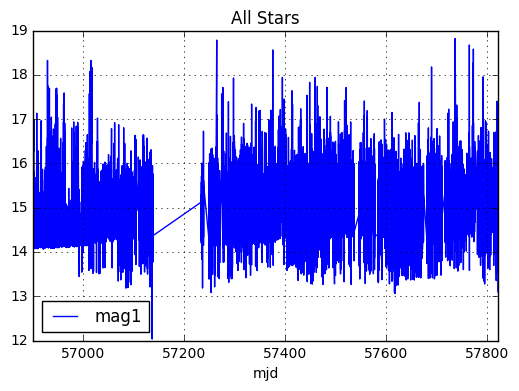

In [28]:
# Plot instrumental mag1 vs. MJD for all stars observed over all 3 years...
ax = magobsdf.plot('mjd','mag1', grid=True)
ax.set_title("All Stars")

** With multiple stars and with various conditions (e.g., clouds), it is hard to interpret the above plot. **

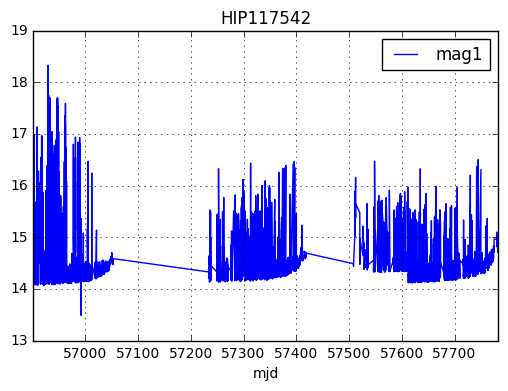

In [29]:
# Let's plot instrumental mag1 vs. MJD for 'HIP117542' for all 3 years...
ax = magobsdf[(magobsdf.object=='HIP117452')].plot('mjd','mag1', grid=True)
ax.set_title("HIP117542")

** Variable cloudiness causes the spikes to larger (fainter) magnitudes.  Note, however, the base of the plot:  generally it is mostly flat (but, if you look closely, there is a slight trend towards larger/fainter mags with time due to dust accumulation on the aTmCam lenses).  At about MJD57610, there is a jump, due to a lens-cleaning event.  The upward curves near MJD57050, near MJD57400, and near MJD57770 are due to HIP117542 being at high-airmass towards the end of its observing season in these three separate years.**

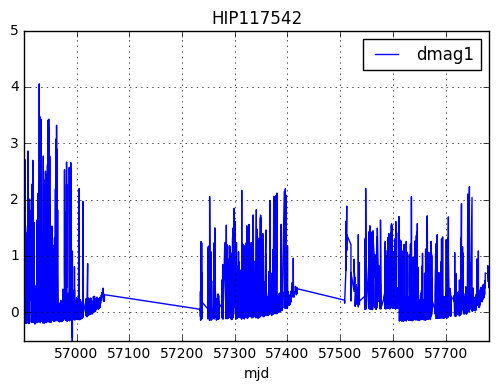

In [30]:
# Let's plot instrumental dmag1 vs. MJD for 'HIP117542' for all 3 years...
ax = magobsdf[(magobsdf.object=='HIP117452')].plot('mjd','dmag1', grid=True, ylim=[-0.5,5.0])
ax.set_title("HIP117542")

** Same as the previous plot, but with the median mag1 of HIP75501 subtracted off.  **

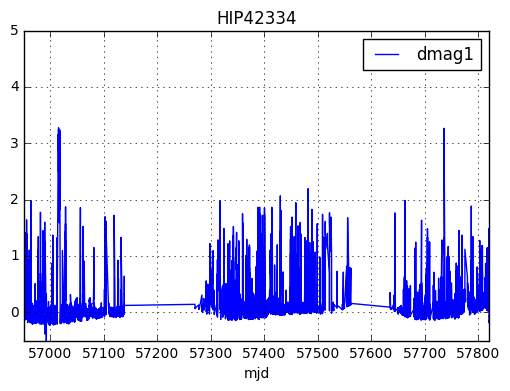

In [31]:
# Plot the instrumental dmag1 for 'HIP42334' vs. MJD...
ax = magobsdf[(magobsdf.object=='HIP42334')].plot('mjd','dmag1', grid=True, ylim=[-0.5,5.0])
ax.set_title("HIP42334")

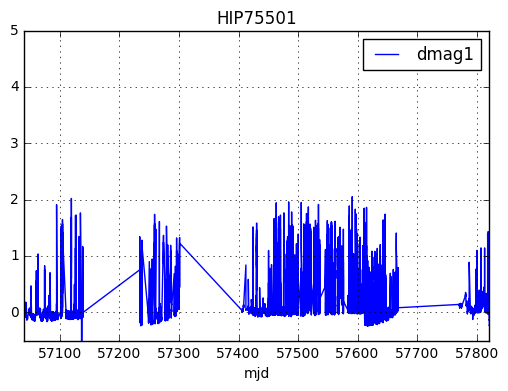

In [32]:
# Plot the instrumental dmag1 for 'HIP75501' vs. MJD...
ax = magobsdf[(magobsdf.object=='HIP75501')].plot('mjd','dmag1', grid=True, ylim=[-0.5,5.0])
ax.set_title("HIP75501")

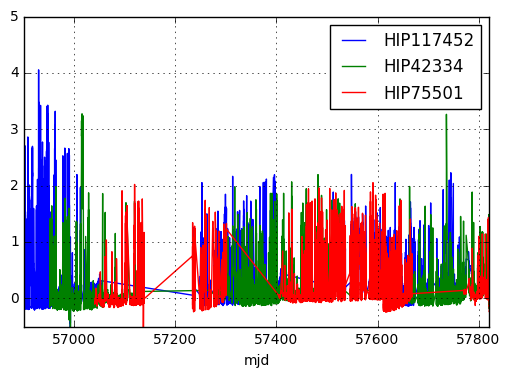

In [33]:
# Plot all 3 main Hipparcos stars together...
ax = magobsdf[(magobsdf.object=='HIP117452')].plot('mjd','dmag1', grid=True, ylim=[-0.5,5.0])
magobsdf[(magobsdf.object=='HIP42334')].plot('mjd','dmag1', grid=True, ylim=[-0.5,5.0], ax=ax)
magobsdf[(magobsdf.object=='HIP75501')].plot('mjd','dmag1', grid=True, ylim=[-0.5,5.0], ax=ax)
ax.legend(labels=['HIP117452','HIP42334','HIP75501'])

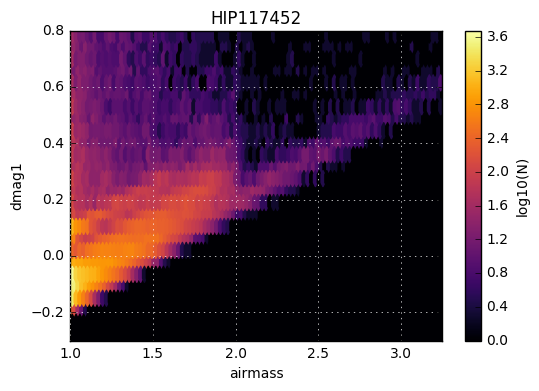

In [34]:
# Let's plot a 2D histogram of log(Nobs), binned by delta_mag1 and airmass, for 'HIP117452'...

x=magobsdf[(magobsdf.object=='HIP117452')].airmass
y=magobsdf[(magobsdf.object=='HIP117452')].dmag1
xmin = 1.0
xmax = 3.25
ymin = -0.3
ymax = 0.8

fig, axs = plt.subplots(ncols=1)

ax=axs
hb = ax.hexbin(x, y, gridsize=100, bins='log', cmap='inferno')
ax.axis([xmin, xmax, ymin, ymax])
ax.set_title("HIP117452")
ax.set_xlabel("airmass")
ax.set_ylabel("dmag1")
cb = fig.colorbar(hb, ax=ax)
cb.set_label('log10(N)')
plt.grid(True)
ax.grid(color='white')

plt.show()

** Although this plot contains data observed under both photometric and non-photometric conditions, and with a system throughput that varies over the course of the 3 years, note the clear linear relation between dmag1 and airmass along the lower edge of the plot...  Clearly nice evidence for a linear first-order extinction term...  **

***
**Next, let's investigate mag2, which is at 520 nm...**

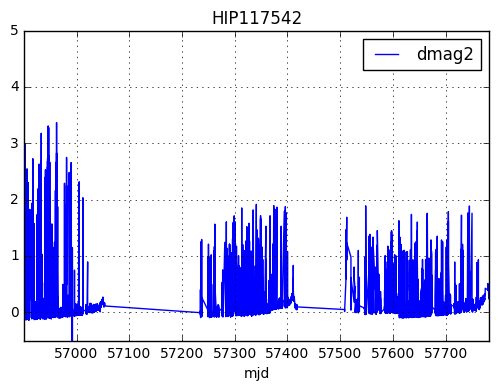

In [35]:
# Let's plot instrumental dmag2 vs. MJD for 'HIP117542' for all 3 years...
ax = magobsdf[(magobsdf.object=='HIP117452')].plot('mjd','dmag2', grid=True, ylim=[-0.5,5.0])
ax.set_title("HIP117542")

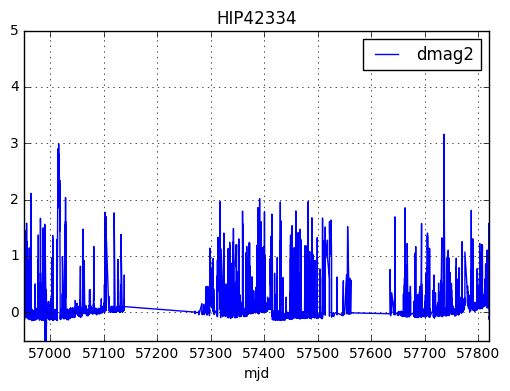

In [36]:
# Plot the instrumental dmag2 for 'HIP42334' vs. MJD...
ax = magobsdf[(magobsdf.object=='HIP42334')].plot('mjd','dmag2', grid=True, ylim=[-0.5,5.0])
ax.set_title("HIP42334")

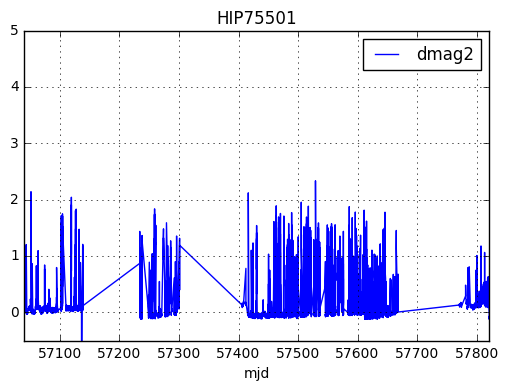

In [37]:
# Plot the instrumental dmag2 for 'HIP75501' vs. MJD...
ax = magobsdf[(magobsdf.object=='HIP75501')].plot('mjd','dmag2', grid=True, ylim=[-0.5,5.0])
ax.set_title("HIP75501")

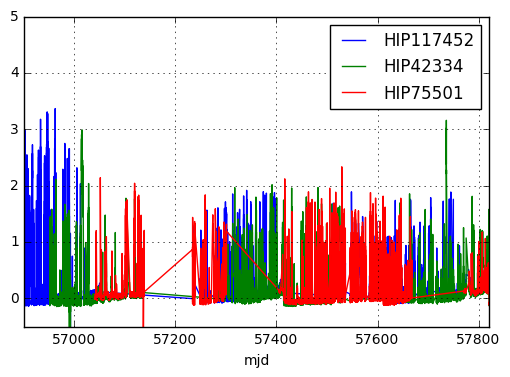

In [38]:
# Plot all 3 main Hipparcos stars together...
ax = magobsdf[(magobsdf.object=='HIP117452')].plot('mjd','dmag2', grid=True, ylim=[-0.5,5.0])
magobsdf[(magobsdf.object=='HIP42334')].plot('mjd','dmag2', grid=True, ylim=[-0.5,5.0], ax=ax)
magobsdf[(magobsdf.object=='HIP75501')].plot('mjd','dmag2', grid=True, ylim=[-0.5,5.0], ax=ax)
ax.legend(labels=['HIP117452','HIP42334','HIP75501'])

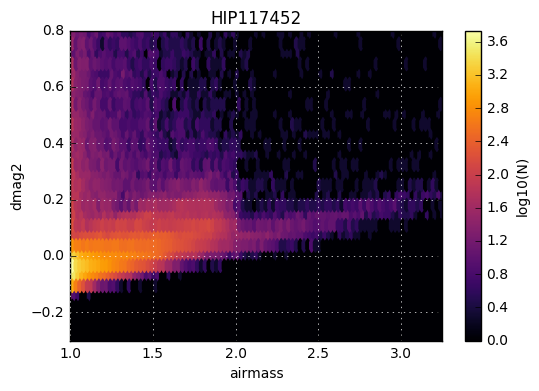

In [39]:
# Let's plot a 2D histogram of log(Nobs), binned by dmag2 and airmass, for 'HIP117452'...

x=magobsdf[(magobsdf.object=='HIP117452')].airmass
y=magobsdf[(magobsdf.object=='HIP117452')].dmag2
xmin = 1.0
xmax = 3.25
ymin = -0.3
ymax = 0.8

fig, axs = plt.subplots(ncols=1)

ax=axs
hb = ax.hexbin(x, y, gridsize=100, bins='log', cmap='inferno')
ax.axis([xmin, xmax, ymin, ymax])
ax.set_title("HIP117452")
ax.set_xlabel("airmass")
ax.set_ylabel("dmag2")
cb = fig.colorbar(hb, ax=ax)
cb.set_label('log10(N)')
plt.grid(True)
ax.grid(color='white')

plt.show()

** Although this plot contains data observed under both photometric and non-photometric conditions, and with a system throughput that varies over the course of the 3 years, note the clear linear relation between delta_mag2 and airmass along the lower edge of the plot (similar to that of the corresponding plot for dmag1)...  There is still evidence for a nice linear extinction term, but it is shallower than for dmag1... **

***
**Next, let's investigate mag3, which is at 852 nm...**

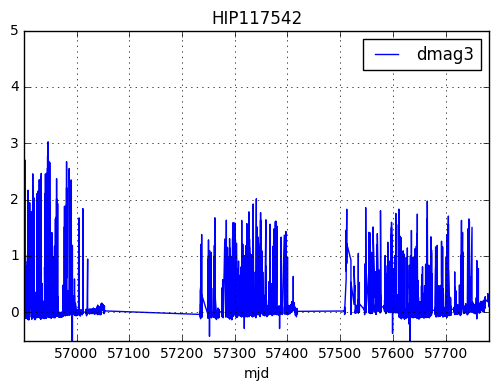

In [40]:
# Let's plot instrumental dmag3 vs. MJD for 'HIP117542' for all 3 years...
ax = magobsdf[(magobsdf.object=='HIP117452')].plot('mjd','dmag3', grid=True, ylim=[-0.5,5.0])
ax.set_title("HIP117542")

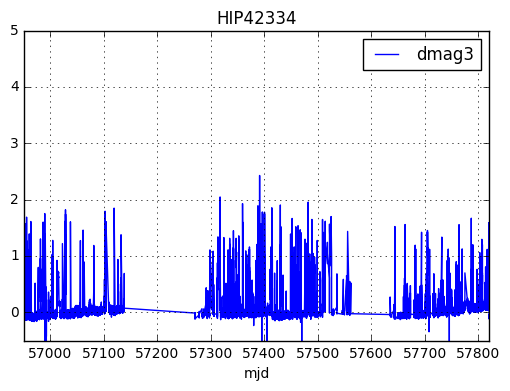

In [41]:
# Plot the instrumental dmag3 for 'HIP42334' vs. MJD...
ax = magobsdf[(magobsdf.object=='HIP42334')].plot('mjd','dmag3', grid=True, ylim=[-0.5,5.0])
ax.set_title("HIP42334")

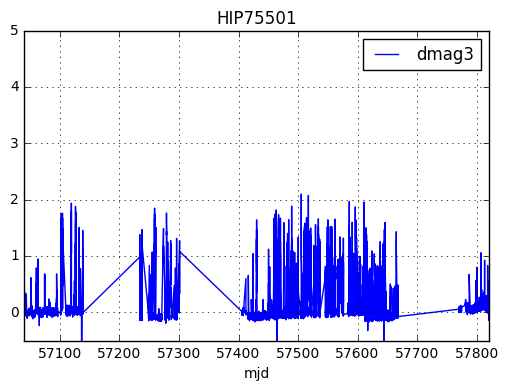

In [42]:
# Plot the instrumental dmag3 for 'HIP75501' vs. MJD...
ax = magobsdf[(magobsdf.object=='HIP75501')].plot('mjd','dmag3', grid=True, ylim=[-0.5,5.0])
ax.set_title("HIP75501")

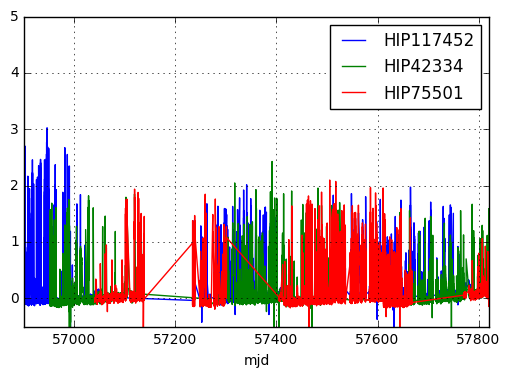

In [43]:
# Plot all 3 main Hipparcos stars together...
ax = magobsdf[(magobsdf.object=='HIP117452')].plot('mjd','dmag3', grid=True, ylim=[-0.5,5.0])
magobsdf[(magobsdf.object=='HIP42334')].plot('mjd','dmag3', grid=True, ylim=[-0.5,5.0], ax=ax)
magobsdf[(magobsdf.object=='HIP75501')].plot('mjd','dmag3', grid=True, ylim=[-0.5,5.0], ax=ax)
ax.legend(labels=['HIP117452','HIP42334','HIP75501'])

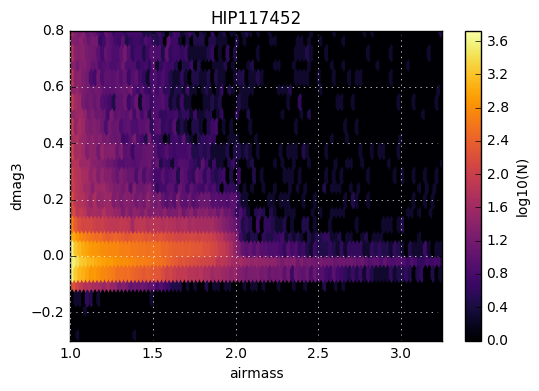

In [44]:
# Let's plot a 2D histogram of log(Nobs), binned by dmag3 and airmass, for 'HIP117452'...

x=magobsdf[(magobsdf.object=='HIP117452')].airmass
y=magobsdf[(magobsdf.object=='HIP117452')].dmag3
xmin = 1.0
xmax = 3.25
ymin = -0.3
ymax = 0.8

fig, axs = plt.subplots(ncols=1)

ax=axs
hb = ax.hexbin(x, y, gridsize=100, bins='log', cmap='inferno')
ax.axis([xmin, xmax, ymin, ymax])
ax.set_title("HIP117452")
ax.set_xlabel("airmass")
ax.set_ylabel("dmag3")
cb = fig.colorbar(hb, ax=ax)
cb.set_label('log10(N)')
plt.grid(True)
ax.grid(color='white')

plt.show()

** Although this plot contains data observed under both photometric and non-photometric conditions, and with a system throughput that varies over the course of the 3 years, note the clear linear relation between dmag3 and airmass along the lower edge of the plot...  Unlike for dmag1 and delta_mag2, the slope is very small -- almost zero. **

***
**Next, let's investigate mag4, which is at 940 nm (i.e., right in the middle of the precipitable water band feature in z-band)...**

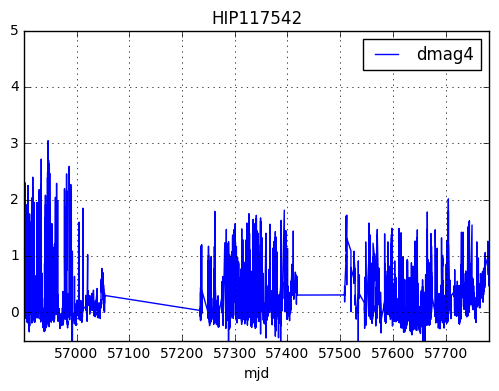

In [45]:
# Let's plot instrumental dmag4 vs. MJD for 'HIP117542' for all 3 years...
ax = magobsdf[(magobsdf.object=='HIP117452')].plot('mjd','dmag4', grid=True, ylim=[-0.5,5.0])
ax.set_title("HIP117542")

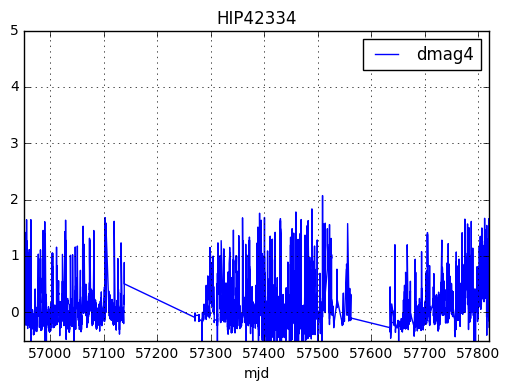

In [46]:
# Plot the instrumental dmag3 for 'HIP42334' vs. MJD...
ax = magobsdf[(magobsdf.object=='HIP42334')].plot('mjd','dmag4', grid=True, ylim=[-0.5,5.0])
ax.set_title("HIP42334")

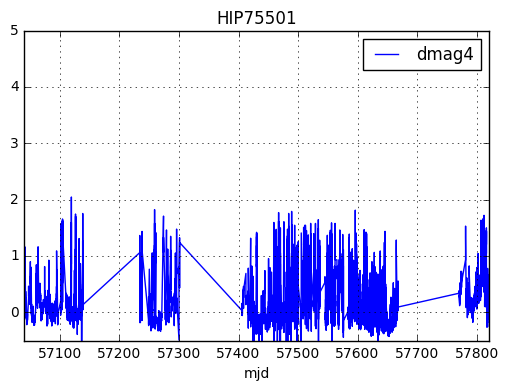

In [47]:
# Plot the instrumental dmag2 for 'HIP75501' vs. MJD...
ax = magobsdf[(magobsdf.object=='HIP75501')].plot('mjd','dmag4', grid=True, ylim=[-0.5,5.0])
ax.set_title("HIP75501")

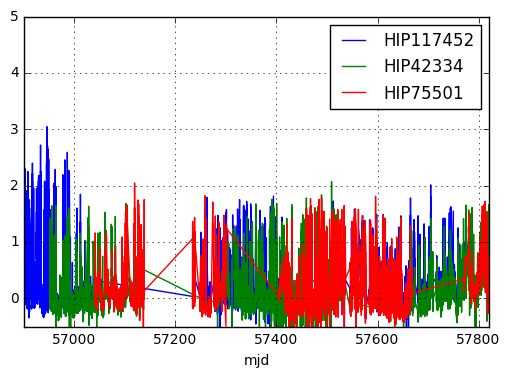

In [48]:
# Plot all 3 main Hipparcos stars together...
ax = magobsdf[(magobsdf.object=='HIP117452')].plot('mjd','dmag4', grid=True, ylim=[-0.5,5.0])
magobsdf[(magobsdf.object=='HIP42334')].plot('mjd','dmag4', grid=True, ylim=[-0.5,5.0], ax=ax)
magobsdf[(magobsdf.object=='HIP75501')].plot('mjd','dmag4', grid=True, ylim=[-0.5,5.0], ax=ax)
ax.legend(labels=['HIP117452','HIP42334','HIP75501'])

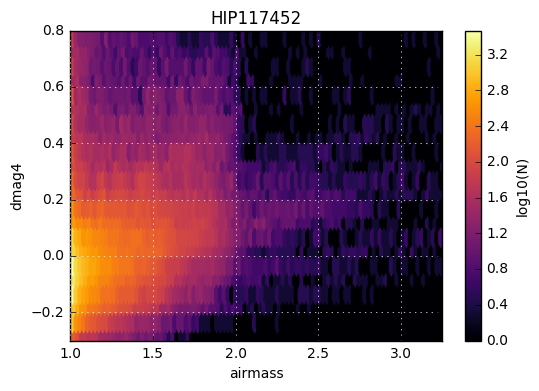

In [49]:
# Let's plot a 2D histogram of log(Nobs), binned by dmag3 and airmass, for 'HIP117452'...

x=magobsdf[(magobsdf.object=='HIP117452')].airmass
y=magobsdf[(magobsdf.object=='HIP117452')].dmag4
xmin = 1.0
xmax = 3.25
ymin = -0.3
ymax = 0.8

fig, axs = plt.subplots(ncols=1)

ax=axs
hb = ax.hexbin(x, y, gridsize=100, bins='log', cmap='inferno')
ax.axis([xmin, xmax, ymin, ymax])
ax.set_title("HIP117452")
ax.set_xlabel("airmass")
ax.set_ylabel("dmag4")
cb = fig.colorbar(hb, ax=ax)
cb.set_label('log10(N)')
plt.grid(True)
ax.grid(color='white')

plt.show()

** Unlike for delta_mag1 and delta_mag2, and delta_mag3, there is no clear sign of a single 
linear delta_mag3 vs. airmass relation.  This is, of course, because the amount of 
 precipitable water vapor (PWV) strongly affects the value of delta_mag3... **

***
### Precipitable Water Vapor (PWV)

**Let's look more into the effects of PWV on the aTmCam mags.**

We have two sources of PWV measurements.  One derived from GPS monitor ("GPSmon") and another derived directly from aTmCam itself (based on the mag3-mag4 colors).

***
** Let's first look at the GPSmon measurements...**

In [50]:
# Where are we?
%pwd

u'/Users/dtucker/Desktop/aTmCam_analysis'

In [51]:
# The Suominet-processed GPSmon data are in one big CSV file, updated daily...
gpsdatafile = 'GPSmon_data/SuominetResults.csv'

# Read it into a pandas DataFrame
# Note, however, the separator is not just a comma, but a comma-plus-a-single-whitespace,
# so we need to note the separator explicitly in the pandas read_csv command...
gpsdf = pd.read_csv(gpsdatafile, sep=', ')

# Let's make sure the DataFrame is sorted by MJD...
gpsdf.sort_values('MJD',inplace=True)

# And let's take a look at it...
gpsdf.head(10)

/Users/dtucker/anaconda2/envs/astroconda/lib/python2.7/site-packages/ipykernel/__main__.py:7: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.


DATE        MJD  Duration  PWV  PWV_ERR  Pressure  Temp  Tdelay
0  20121107/0015  56238.010        30  2.4      0.1     780.0  15.6  1794.3
1  20121107/0045  56238.031        30  1.7      0.1     780.0  15.2  1790.0
2  20121107/0115  56238.052        30  1.9      0.2     780.0  14.9  1791.7
3  20121107/0145  56238.073        30  3.1      0.3     780.0  14.6  1799.0
4  20121107/0215  56238.094        30  3.7      0.1     780.0  14.4  1802.9
5  20121107/0245  56238.115        30  2.9      0.1     780.0  14.3  1798.0
6  20121107/0315  56238.135        30  2.3      0.1     780.0  14.1  1794.0
7  20121107/0345  56238.156        30  2.6      0.1     780.0  13.7  1795.9
8  20121107/0415  56238.177        30  2.2      0.1     780.0  13.8  1793.3
9  20121107/0445  56238.198        30  2.2      0.1     779.7  13.8  1793.0

In [52]:
# Grab a clean sample...
mask = ( (gpsdf.PWV >= 0.00) & (gpsdf.PWV_ERR < 2.0) & (gpsdf.Pressure > 700.) & (gpsdf.Pressure < 850.) & (gpsdf.Temp > -20.) & (gpsdf.Temp < 50.) )
clean_gpsdf = gpsdf[mask].copy()

# And let's take a look at it...
clean_gpsdf.head(10)

DATE        MJD  Duration  PWV  PWV_ERR  Pressure  Temp  Tdelay
0  20121107/0015  56238.010        30  2.4      0.1     780.0  15.6  1794.3
1  20121107/0045  56238.031        30  1.7      0.1     780.0  15.2  1790.0
2  20121107/0115  56238.052        30  1.9      0.2     780.0  14.9  1791.7
3  20121107/0145  56238.073        30  3.1      0.3     780.0  14.6  1799.0
4  20121107/0215  56238.094        30  3.7      0.1     780.0  14.4  1802.9
5  20121107/0245  56238.115        30  2.9      0.1     780.0  14.3  1798.0
6  20121107/0315  56238.135        30  2.3      0.1     780.0  14.1  1794.0
7  20121107/0345  56238.156        30  2.6      0.1     780.0  13.7  1795.9
8  20121107/0415  56238.177        30  2.2      0.1     780.0  13.8  1793.3
9  20121107/0445  56238.198        30  2.2      0.1     779.7  13.8  1793.0

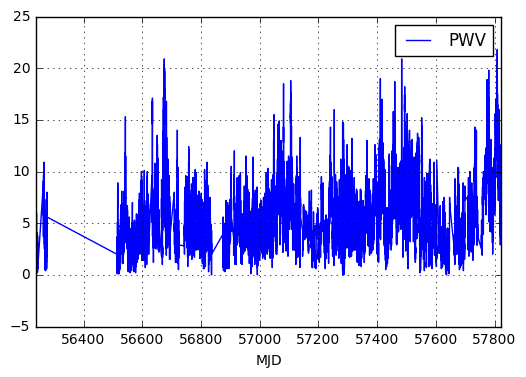

In [53]:
# Plot the GPSmon PWV vs. MJD...
ax = clean_gpsdf.plot('MJD','PWV', grid=True, ylim=[-5,25.0])

In [54]:
# For future reference, let's add an integer MJD column to the GPSmon DataFrame...
clean_gpsdf['imjd'] = np.floor(clean_gpsdf['MJD']+0.3).astype(int)

# And let's see how many unique nights of GPSmon data we have...
len(clean_gpsdf['imjd'].unique())

1158

In [55]:
# List the unique nights from the aTmCam data...
magobsdf['imjd'].unique()

array([56901, 56902, 56903, 56904, 56906, 56907, 56908, 56909, 56910,
       56911, 56915, 56916, 56917, 56918, 56919, 56920, 56921, 56922,
       56923, 56924, 56925, 56926, 56927, 56928, 56929, 56930, 56931,
       56932, 56933, 56934, 56935, 56936, 56937, 56938, 56939, 56940,
       56941, 56942, 56943, 56944, 56945, 56946, 56947, 56948, 56949,
       56950, 56951, 56952, 56953, 56954, 56955, 56956, 56957, 56958,
       56959, 56960, 56961, 56962, 56963, 56964, 56965, 56966, 56967,
       56968, 56969, 56970, 56971, 56972, 56973, 56974, 56975, 56976,
       56977, 56978, 56979, 56980, 56981, 56982, 56983, 56984, 56986,
       56987, 56988, 56989, 56990, 56991, 56992, 56996, 56997, 56998,
       56999, 57000, 57001, 57002, 57003, 57004, 57005, 57006, 57007,
       57008, 57009, 57010, 57011, 57012, 57013, 57014, 57015, 57016,
       57017, 57018, 57019, 57020, 57021, 57022, 57025, 57026, 57027,
       57028, 57029, 57030, 57031, 57032, 57033, 57034, 57035, 57036,
       57037, 57038,

In [56]:
# Create a sorted list of all imjds that lie within both the GPS and the aTmCam data sets...
mjd_atm_gps_list = sorted(list(set(clean_gpsdf['imjd'].unique()) & set(magobsdf['imjd'].unique())))

len(mjd_atm_gps_list)

634

In [57]:
# Create a linear interpolation function for the GPS PWV data...
gps_pwv_interp1d = interpolate.interp1d(clean_gpsdf['MJD'], clean_gpsdf['PWV'], kind='linear')

In [58]:
# Grab the list of MJDs from the aTmCam instrumental mag DataFrame...
# To avoid issues later on, we only include those that are within the range of the GPS data...
mask = magobsdf['mjd'] < gpsdf['MJD'].max()
magobsdf = magobsdf[mask].copy()

mjd_array = np.array(magobsdf['mjd'])
mjd_array

array([ 56901.21238,  56901.21491,  56901.22771, ...,  57821.41056,
        57821.41109,  57821.41162])

In [59]:
# Find the (interpolated) GPSmon PWV values for the MJDs from the aTmCam instr. mag DataFrame...
pwv_array = gps_pwv_interp1d(mjd_array)
pwv_array

array([ 7.9       ,  7.9       ,  8.02442857, ...,  4.56514286,
        4.57271429,  4.58028571])

In [60]:
# Convert the mjd_array and pwv_array into their own Pandas DataFrame...
mjd_series = pd.Series(mjd_array, name='mjd')
pwv_series = pd.Series(pwv_array, name='pwv')
mjdpwvdf = pd.concat([mjd_series, pwv_series], axis=1)
mjdpwvdf.head(10)

mjd       pwv
0  56901.21238  7.900000
1  56901.21491  7.900000
2  56901.22771  8.024429
3  56901.22822  8.031714
4  56901.24617  7.984050
5  56901.24869  7.895850
6  56901.24920  7.878000
7  56901.25334  7.733100
8  56902.16113  6.946571
9  56902.16311  7.003143

In [61]:
# Match (merge) the GPSmon PWV values with the aTmCam instr. mag DataFrame...
#magobsdf_new = pd.merge(magobsdf, mjdpwvdf, on=['mjd', 'mjd'], how='inner')
magobsdf_new = pd.merge(magobsdf, mjdpwvdf, on='mjd', how='inner')
magobsdf_new.head(10)

expid                 date-obs          mjd     object        obj_ra  \
0    237  2014-09-01T05:05:50.000  56901.21238  HIP117452  23:49:42.610   
1    242  2014-09-01T05:09:28.000  56901.21491  HIP117452  23:49:42.610   
2    257  2014-09-01T05:27:54.000  56901.22771  HIP117452  23:49:42.610   
3    258  2014-09-01T05:28:38.000  56901.22822  HIP117452  23:49:42.610   
4    279  2014-09-01T05:54:29.000  56901.24617  HIP105140  21:18:51.001   
5    284  2014-09-01T05:58:07.000  56901.24869  HIP105140  21:18:51.001   
6    285  2014-09-01T05:58:51.000  56901.24920  HIP105140  21:18:51.001   
7    289  2014-09-01T06:04:49.000  56901.25334  HIP110578  22:24:54.299   
8    284  2014-09-02T03:52:02.000  56902.16113  HIP117452  23:49:42.623   
9    286  2014-09-02T03:54:53.000  56902.16311  HIP117452  23:49:42.623   

         obj_dec  airmass     mag1     mag2     mag3    ...     UT_hour  \
0  -28:02:42.563   1.0163  14.9742  14.7739  16.8629    ...     5.09712   
1  -28:02:42.563   1.0139  14.5875  14.4159  16.5093    ...     5.15784   
2  -28:02:42.563   1.0049  14.8078  14.5752  16.7427    ...     5.46504   
3  -28:02:42.563   1.0046  14.9070  14.7155  16.7495    ...     5.47728   
4  -32:06:26.609   1.1897  15.1957  14.8990  16.8779    ...     5.90808   
5  -32:06:26.609   1.2001  14.6956  14.3202  16.3068    ...     5.96856   
6  -32:06:26.609   1.2023  14.9313  14.5296  16.5423    ...     5.98080   
7  -04:45:31.103   1.2287  16.5218  16.3684  18.6170    ...     6.08016   
8  -28:02:42.618   1.1068  16.8462  16.5588  18.7460    ...     3.86712   
9  -28:02:42.618   1.1012  16.5383  16.3203  18.0426    ...     3.91464   

   median_mag1  median_mag2  median_mag3  median_mag4   dmag1   dmag2   dmag3  \
0      14.2714      14.2714      14.2714      14.2714  0.7028  0.8005  0.8192   
1      14.2714      14.2714      14.2714      14.2714  0.3161  0.4425  0.4656   
2      14.2714      14.2714      14.2714      14.2714  0.5364  0.6018  0.6990   
3      14.2714      14.2714      14.2714      14.2714  0.6356  0.7421  0.7058   
4      14.5338      14.5338      14.5338      14.5338  0.6619  0.7683  0.7946   
5      14.5338      14.5338      14.5338      14.5338  0.1618  0.1895  0.2235   
6      14.5338      14.5338      14.5338      14.5338  0.3975  0.3989  0.4590   
7      15.4651      15.4651      15.4651      15.4651  1.0567  1.1779  1.3171   
8      14.2714      14.2714      14.2714      14.2714  2.5748  2.5854  2.7023   
9      14.2714      14.2714      14.2714      14.2714  2.2669  2.3469  1.9989   

    dmag4       pwv  
0  0.8799  7.900000  
1  0.5721  7.900000  
2  0.1410  8.024429  
3  0.4127  8.031714  
4 -0.0883  7.984050  
5  0.2689  7.895850  
6  0.4935  7.878000  
7 -1.6021  7.733100  
8  1.6900  6.946571  
9  1.9613  7.003143  

[10 rows x 42 columns]

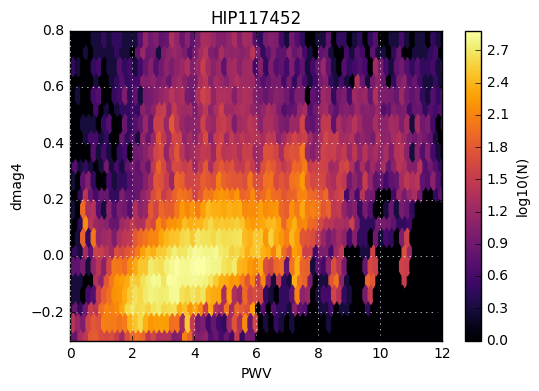

In [62]:
# Let's plot a 2D histogram of log(Nobs), binned by dmag4 and PWV, for 'HIP117452'...

x=magobsdf_new[(magobsdf_new.object=='HIP117452')].pwv
y=magobsdf_new[(magobsdf_new.object=='HIP117452')].dmag4
xmin = 0.0
xmax = 12.0
ymin = -0.3
ymax = 0.8

fig, axs = plt.subplots(ncols=1)

ax=axs
hb = ax.hexbin(x, y, gridsize=100, bins='log', cmap='inferno')
ax.axis([xmin, xmax, ymin, ymax])
ax.set_title("HIP117452")
ax.set_xlabel("PWV")
ax.set_ylabel("dmag4")
cb = fig.colorbar(hb, ax=ax)
cb.set_label('log10(N)')
plt.grid(True)
ax.grid(color='white')

plt.show()

** dmag4 is much more strongly correlated with PWV than with airmasss... **

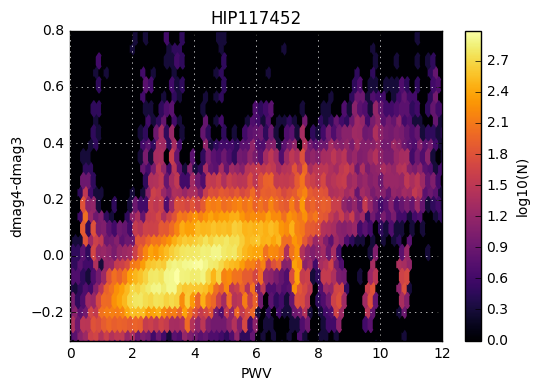

In [63]:
# If we plot dmag4-dmag3, we can remove the effects of clouds...

x=magobsdf_new[(magobsdf_new.object=='HIP117452')].pwv
y1=magobsdf_new[(magobsdf_new.object=='HIP117452')].dmag4
y2=magobsdf_new[(magobsdf_new.object=='HIP117452')].dmag3
y=y1-y2
xmin = 0.0
xmax = 12.0
ymin = -0.3
ymax = 0.8

fig, axs = plt.subplots(ncols=1)

ax=axs
hb = ax.hexbin(x, y, gridsize=100, bins='log', cmap='inferno')
ax.axis([xmin, xmax, ymin, ymax])
ax.set_title("HIP117452")
ax.set_xlabel("PWV")
ax.set_ylabel("dmag4-dmag3")
cb = fig.colorbar(hb, ax=ax)
cb.set_label('log10(N)')
plt.grid(True)
ax.grid(color='white')

plt.show()

** The correlation of delta_mag4-delta_mag3 with PWV is even better than 
the correlation of delta_mag4 with PWV... **

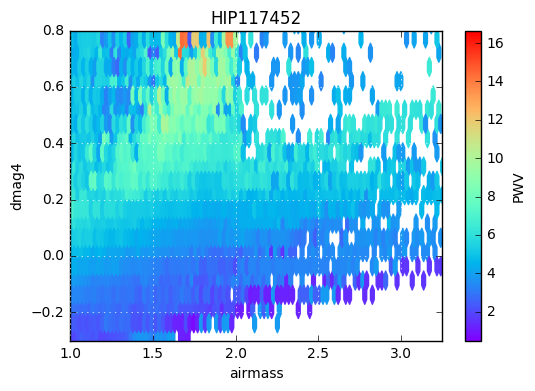

In [64]:
# This is like the original dmag4 vs. airmass plot, but now color-coded by PWV...

x=magobsdf_new[(magobsdf_new.object=='HIP117452')].airmass
y=magobsdf_new[(magobsdf_new.object=='HIP117452')].dmag4
z=magobsdf_new[(magobsdf_new.object=='HIP117452')].pwv
xmin = 1.0
xmax = 3.25
ymin = -0.3
ymax = 0.8

fig, axs = plt.subplots(ncols=1)

ax=axs
hb = ax.hexbin(x, y, C=z, gridsize=100, cmap='rainbow', reduce_C_function=np.median)
ax.axis([xmin, xmax, ymin, ymax])
ax.set_title("HIP117452")
ax.set_xlabel("airmass")
ax.set_ylabel("dmag4")
cb = fig.colorbar(hb, ax=ax)
cb.set_label('PWV')
plt.grid(True)
ax.grid(color='white')

plt.show()

** Some evidence of correlation of delta_mag4 with PWV, but maybe we can do better... **

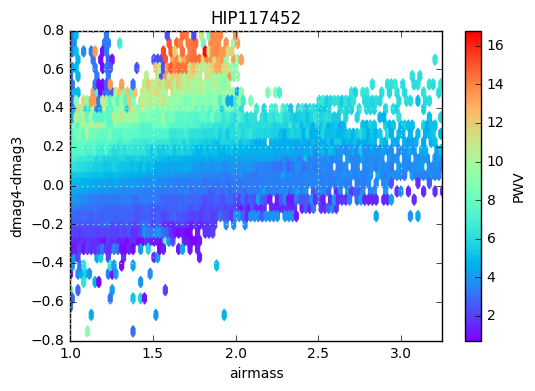

In [65]:
# Same as above, but now dmag4-dmag3 vs. airmass, color-coded by PWV...

x=magobsdf_new[(magobsdf_new.object=='HIP117452')].airmass
y1=magobsdf_new[(magobsdf_new.object=='HIP117452')].dmag4
y2=magobsdf_new[(magobsdf_new.object=='HIP117452')].dmag3
y=y1-y2
z=magobsdf_new[(magobsdf_new.object=='HIP117452')].pwv
xmin = 1.0
xmax = 3.25
ymin = -0.8
ymax = 0.8

fig, axs = plt.subplots(ncols=1)

ax=axs
hb = ax.hexbin(x, y, C=z, gridsize=100, cmap='rainbow', reduce_C_function=np.median)
ax.axis([xmin, xmax, ymin, ymax])
ax.set_title("HIP117452")
ax.set_xlabel("airmass")
ax.set_ylabel("dmag4-dmag3")
cb = fig.colorbar(hb, ax=ax)
cb.set_label('PWV')
plt.grid(True)
ax.grid(color='white')

plt.show()

** Very nice, clear correlation! **

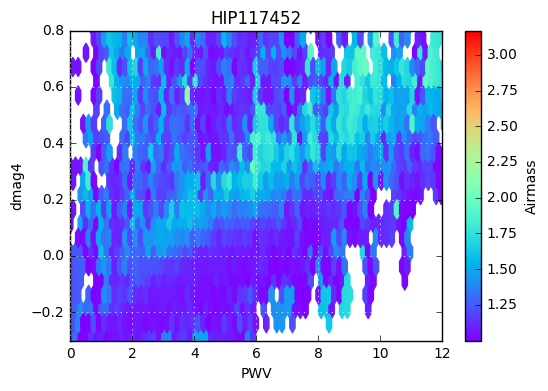

In [66]:
# Let's switch things around a bit, plotting delta_mag4 vs. PWV and color-coding by airmass...

z=magobsdf_new[(magobsdf_new.object=='HIP117452')].airmass
y=magobsdf_new[(magobsdf_new.object=='HIP117452')].dmag4
x=magobsdf_new[(magobsdf_new.object=='HIP117452')].pwv
xmin = 0.0
xmax = 12.0
ymin = -0.3
ymax = 0.8

fig, axs = plt.subplots(ncols=1)

ax=axs
hb = ax.hexbin(x, y, C=z, gridsize=100, cmap='rainbow', reduce_C_function=np.median)
ax.axis([xmin, xmax, ymin, ymax])
ax.set_title("HIP117452")
ax.set_xlabel("PWV")
ax.set_ylabel("dmag4")
cb = fig.colorbar(hb, ax=ax)
cb.set_label('Airmass')
plt.grid(True)
ax.grid(color='white')

plt.show()

** Meh... **

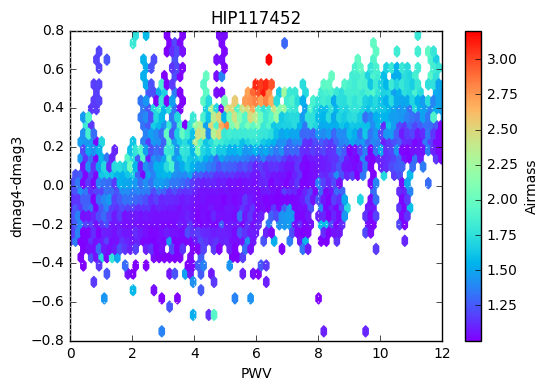

In [67]:
# Same as two figures above, but switching PWV and airmass axes...

z=magobsdf_new[(magobsdf_new.object=='HIP117452')].airmass
y1=magobsdf_new[(magobsdf_new.object=='HIP117452')].dmag4
y2=magobsdf_new[(magobsdf_new.object=='HIP117452')].dmag3
y=y1-y2
x=magobsdf_new[(magobsdf_new.object=='HIP117452')].pwv
xmin = 0.0
xmax = 12.0
ymin = -0.8
ymax = 0.8

fig, axs = plt.subplots(ncols=1)

ax=axs
hb = ax.hexbin(x, y, C=z, gridsize=100, cmap='rainbow', reduce_C_function=np.median)
ax.axis([xmin, xmax, ymin, ymax])
ax.set_title("HIP117452")
ax.set_xlabel("PWV")
ax.set_ylabel("dmag4-dmag3")
cb = fig.colorbar(hb, ax=ax)
cb.set_label('Airmass')
plt.grid(True)
ax.grid(color='white')

plt.show()

** Nice, clear correlation! **

***
** As a slight digression, let's now look at the aTmCam PWV measurements...**

In [68]:
# Ting has generated PWV measurements (and aerosol opacity measurements) from aTmCam, 
# binned every half hour...
# There is one file per year of aTmCam data...
atmResultsList = sorted(glob.glob('aTmCam_data/Test201?/atmcam_half_hour_binning_bin2.txt'))
atmResultsList

['aTmCam_data/Test2014/atmcam_half_hour_binning_bin2.txt',
 'aTmCam_data/Test2015/atmcam_half_hour_binning_bin2.txt',
 'aTmCam_data/Test2016/atmcam_half_hour_binning_bin2.txt']

In [69]:
# Now load the aTmCam files from the 3 years into a single pandas DataFrame, using the
# method we used a few time before...
atmdf_from_each_file = (pd.read_csv(atmResultsFile, 
                                    delim_whitespace=True, 
                                    header=None, comment='#', 
                                    names=['date-obs','mjd','pwv','pwv_err ','tau1','tau1_err','tau2','tau2_err']) 
                        for atmResultsFile in atmResultsList)
atmdf = pd.concat(atmdf_from_each_file, ignore_index=True)

# Let's add an integer MJD column to the aTmCam 
atmdf['imjd'] = np.floor(atmdf['mjd']+0.3).astype(int)

# And let's ensure that the DataFrame is sorted by MJD...
atmdf.sort_values(by='mjd', inplace=True)

# And let's look at the first 10 rows...
atmdf.head(10)

date-obs          mjd    pwv  pwv_err     tau1  tau1_err  \
0     2014-08-31T22:15:00.000  56900.92708 -99.99    -99.99 -99.999   -99.999   
6076  2014-08-31T22:15:00.000  56900.92708 -99.99    -99.99 -99.999   -99.999   
6077  2014-08-31T22:45:00.000  56900.94792 -99.99    -99.99 -99.999   -99.999   
1     2014-08-31T22:45:00.000  56900.94792 -99.99    -99.99 -99.999   -99.999   
2     2014-08-31T23:15:00.000  56900.96875 -99.99    -99.99 -99.999   -99.999   
6078  2014-08-31T23:15:00.000  56900.96875 -99.99    -99.99 -99.999   -99.999   
3     2014-08-31T23:45:00.000  56900.98958 -99.99    -99.99 -99.999   -99.999   
6079  2014-08-31T23:45:00.000  56900.98958 -99.99    -99.99 -99.999   -99.999   
4     2014-09-01T00:15:00.000  56901.01042 -99.99    -99.99 -99.999   -99.999   
6080  2014-09-01T00:15:00.000  56901.01042 -99.99    -99.99 -99.999   -99.999   

        tau2  tau2_err   imjd  
0    -99.999   -99.999  56901  
6076 -99.999   -99.999  56901  
6077 -99.999   -99.999  56901  
1    -99.999   -99.999  56901  
2    -99.999   -99.999  56901  
6078 -99.999   -99.999  56901  
3    -99.999   -99.999  56901  
6079 -99.999   -99.999  56901  
4    -99.999   -99.999  56901  
6080 -99.999   -99.999  56901

In [70]:
# Let's remove any rows for which PWV is less than -10...
clean_atmdf = atmdf[(atmdf.pwv >= -10.)]

# And then look at it...
clean_atmdf.head(10)

date-obs          mjd    pwv  pwv_err    tau1  tau1_err  \
63    2014-09-03T01:45:00.000  56903.07292  10.97      0.10  0.033     0.036   
6139  2014-09-03T01:45:00.000  56903.07292  10.97      0.10  0.033     0.036   
6140  2014-09-03T02:15:00.000  56903.09375  11.23      0.19  0.018     0.043   
64    2014-09-03T02:15:00.000  56903.09375  11.23      0.19  0.018     0.043   
67    2014-09-03T03:45:00.000  56903.15625  10.75      0.14  0.066     0.022   
6143  2014-09-03T03:45:00.000  56903.15625  10.75      0.14  0.066     0.022   
68    2014-09-03T04:15:00.000  56903.17708  10.94      0.13  0.004     0.117   
6144  2014-09-03T04:15:00.000  56903.17708  10.94      0.13  0.004     0.117   
69    2014-09-03T04:45:00.000  56903.19792  10.62      0.11  0.071     0.073   
6145  2014-09-03T04:45:00.000  56903.19792  10.62      0.11  0.071     0.073   

       tau2  tau2_err   imjd  
63    0.036     0.012  56903  
6139  0.036     0.012  56903  
6140  0.023     0.016  56903  
64    0.023     0.016  56903  
67    0.072     0.010  56903  
6143  0.072     0.010  56903  
68    0.047     0.013  56903  
6144  0.047     0.013  56903  
69    0.031     0.014  56903  
6145  0.031     0.014  56903

In [71]:
# How many unique nights of aTmCam data with good PWV measurements do we have?
len(clean_atmdf['imjd'].unique())

619

In [72]:
# Create a sorted list of all imjds that lie within both the GPS and the aTmCam data sets...
mjd_atmcam_gps_list = sorted(list(set(clean_gpsdf['imjd'].unique()) & set(clean_atmdf['imjd'].unique())))

# And how many of these nights are there?
len(mjd_atmcam_gps_list)

572

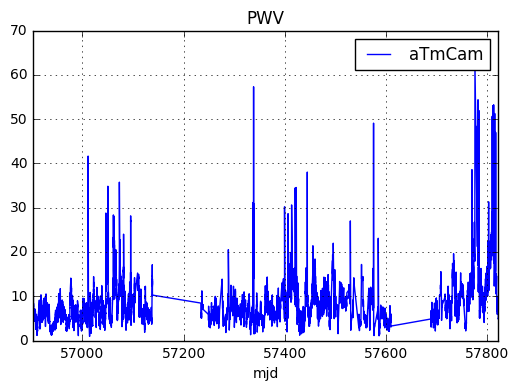

In [73]:
# Plot the aTmCam PWV vs. MJD...
ax = clean_atmdf.plot('mjd','pwv', grid=True)
ax.legend(labels=['aTmCam'])
ax.set_title("PWV")

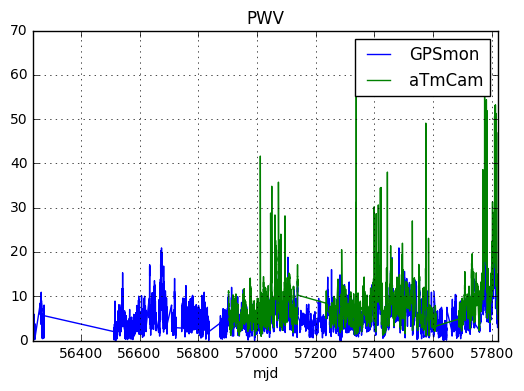

In [74]:
# Plot both the GPSmon and the aTmCam PWV together vs. MJD...
ax = clean_gpsdf.plot('MJD','PWV', grid=True)
clean_atmdf.plot('mjd','pwv', grid=True, ax=ax)
ax.legend(labels=['GPSmon','aTmCam'])
ax.set_title("PWV")

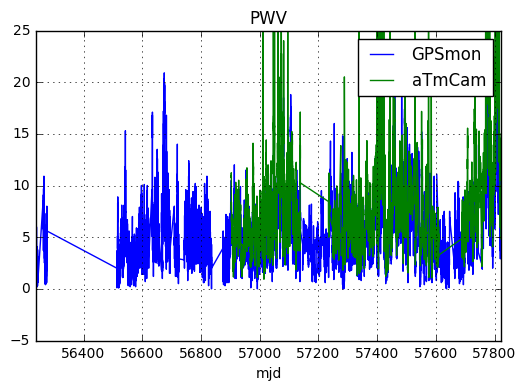

In [75]:
# Zoom in a bit...
ax = clean_gpsdf.plot('MJD','PWV', grid=True, ylim=[-5,25.0])
clean_atmdf.plot('mjd','pwv', grid=True, ylim=[-5,25.0], ax=ax)
ax.legend(labels=['GPSmon','aTmCam'])
ax.set_title("PWV")

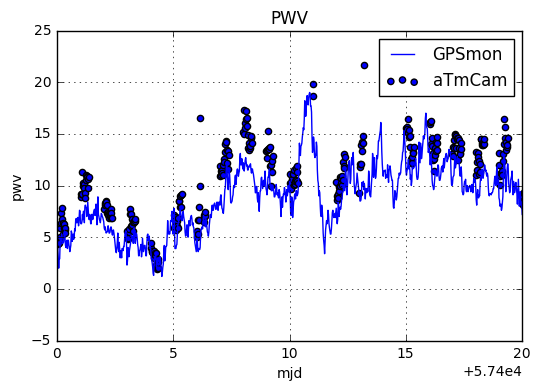

In [76]:
# Zoom in a bit again...
# We will plot the aTmCam data points, not lines...
ax = clean_gpsdf.plot('MJD','PWV', grid=True, xlim=[57400,57420], ylim=[-5,25.0])
clean_atmdf.plot.scatter('mjd','pwv', grid=True, xlim=[57400,57420], ylim=[-5,25.0], ax=ax)
ax.legend(labels=['GPSmon','aTmCam'])
ax.set_title("PWV")

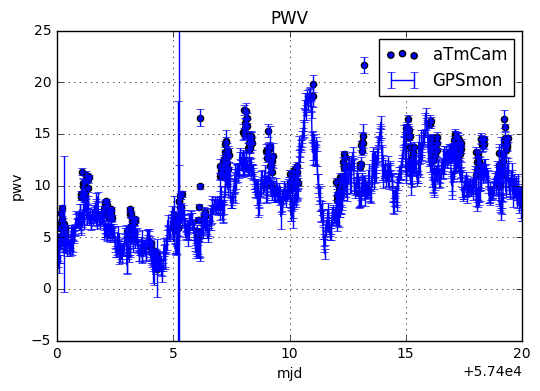

In [77]:
# Zoom in a bit yet again...
# We will plot the aTmCam data points, not lines...
ax = clean_gpsdf.plot('MJD','PWV', grid=True, xlim=[57400,57420], ylim=[-5,25.0], yerr='PWV_ERR')
clean_atmdf.plot.scatter('mjd','pwv', grid=True, xlim=[57400,57420], ylim=[-5,25.0], yerr='pwv_err ', ax=ax)
# Had to switch the order of the labels... but don't know why...
ax.legend(labels=['aTmCam','GPSmon'])
ax.set_title("PWV")

***
### Fitting for dust accumulation on the aTmCam lenses, for airmass-dependent extinction, and for PWV effects on the aTmCam instrumental magnitudes

***
**We first need to remove the effects of clouds.  Then we can fit for dust accumulation, k_airmass, and k_pwv... **

*** 
** Since mag3 has very little airmass- (or PWV-) dependence, variations in dmag3 can serve as both a proxy for cloud effects and dust accumulation, both of which should be pretty much "grey".  Let's look at dmag3 for the very much observed HIP117452... **

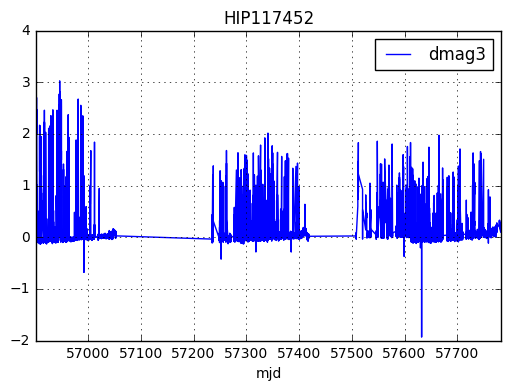

In [78]:
# E.g., look at this plot...
ax = magobsdf_new[(magobsdf_new.object=='HIP117452')].plot('mjd','dmag3', grid=True)
ax.set_title('HIP117452')

** Let's work a bit with just the HIP117452 data from before MJD 57100... **

In [79]:
# We will call the new dataframe df...
df_orig = magobsdf_new[( (magobsdf_new.mjd < 57000.) & (magobsdf_new.object=='HIP117452') )].copy()
df = df_orig.copy()

In [80]:
# First, create a mask that removes the most egregiously bad mag3 exposures...
mask1 = ( np.abs(df['dmag3']) < 1.0 )

# Then, identify and and mask the worst 5% of mag3 exposures remaining (on the "cloudy" side of the distribution)...
df['vigintile'] = pd.qcut( df['dmag3'], 20, labels=False )
mask2 = (df['vigintile']<19)

# Combine mask1 and mask2
mask = mask1 & mask2

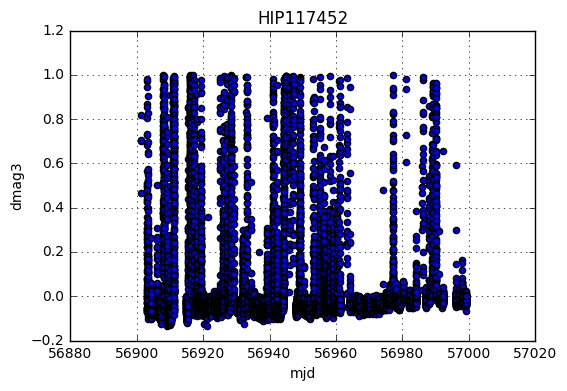

In [81]:
# What does this first-pass cleaned sample look like?
ax = df[mask].plot('mjd','dmag3', grid=True, ylim=[-0.2,1.2], kind='scatter')
ax.set_title('HIP117452')

** Still lots of clouds...  We will have to do some iterative sigma-clipping... **

   iter1...
  RMS:  0.196123
Number of rows remaining:  26429
  mags per 100 days:  -0.064060

   iter2...
  RMS:  0.119684
Number of rows remaining:  25390
  mags per 100 days:  -0.010200

   iter3...
  RMS:  0.070396
Number of rows remaining:  24424
  mags per 100 days:  0.031060

   iter4...
  RMS:  0.042497
Number of rows remaining:  23551
  mags per 100 days:  0.050951

   iter5...
  RMS:  0.028836
Number of rows remaining:  22792
  mags per 100 days:  0.058461

   iter6...
  RMS:  0.022743
Number of rows remaining:  22184
  mags per 100 days:  0.061024

   iter7...
  RMS:  0.020664
Number of rows remaining:  21842
  mags per 100 days:  0.061924

   iter8...
  RMS:  0.019974
Number of rows remaining:  21686
  mags per 100 days:  0.062175

   iter9...
  RMS:  0.019715
Number of rows remaining:  21620
  mags per 100 days:  0.062270



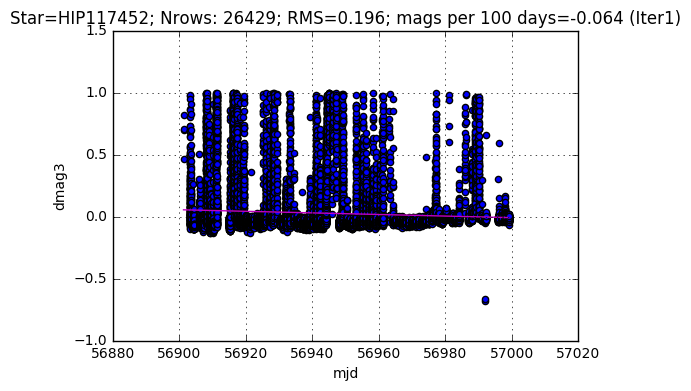

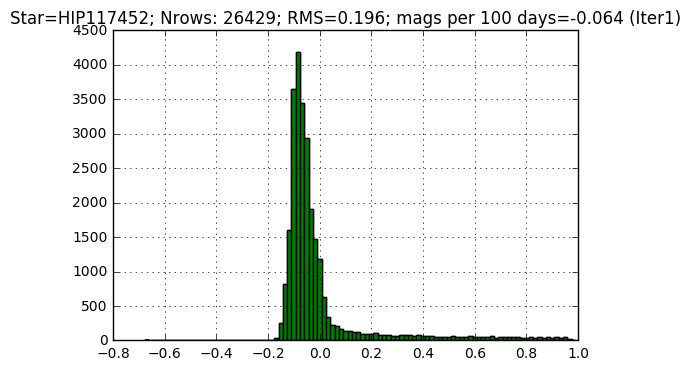

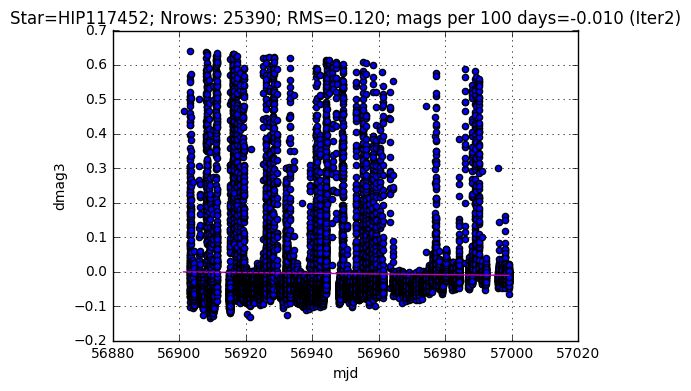

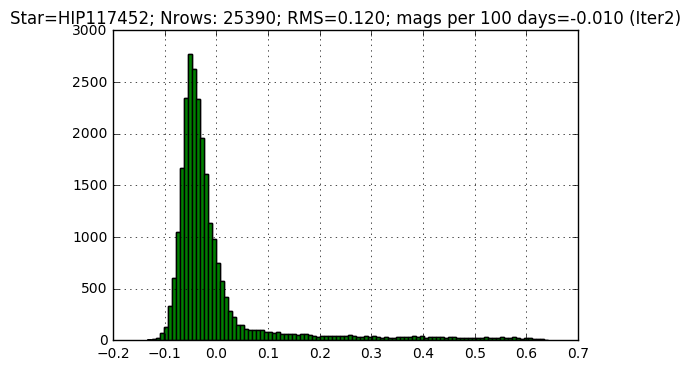

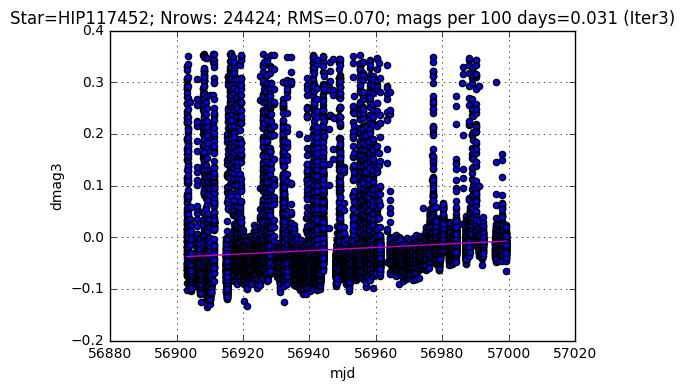

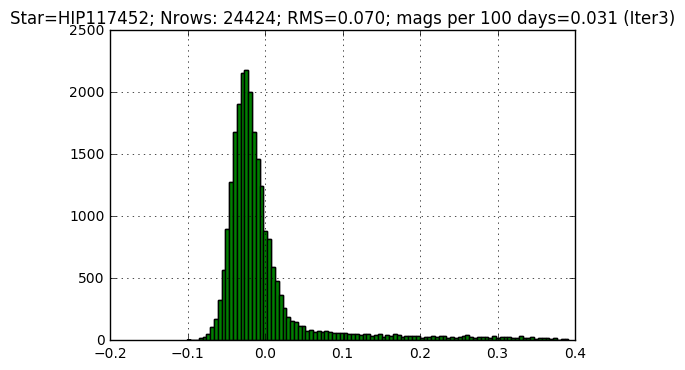

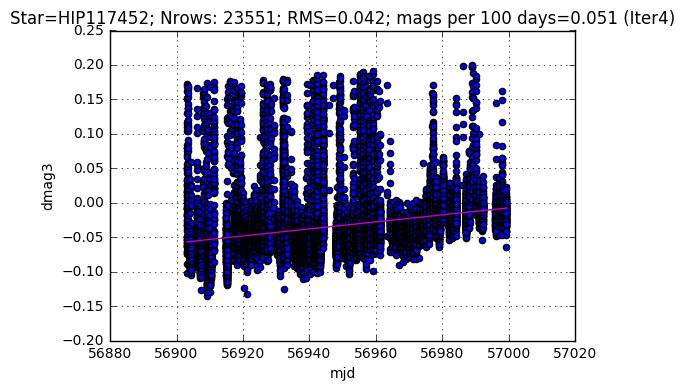

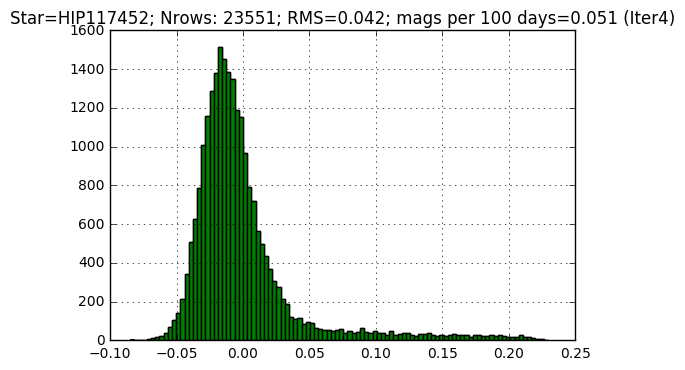

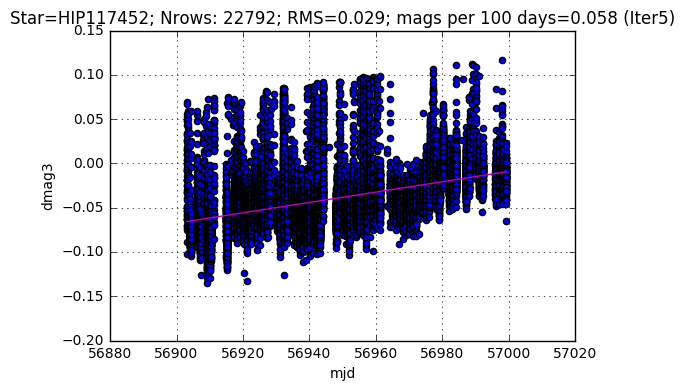

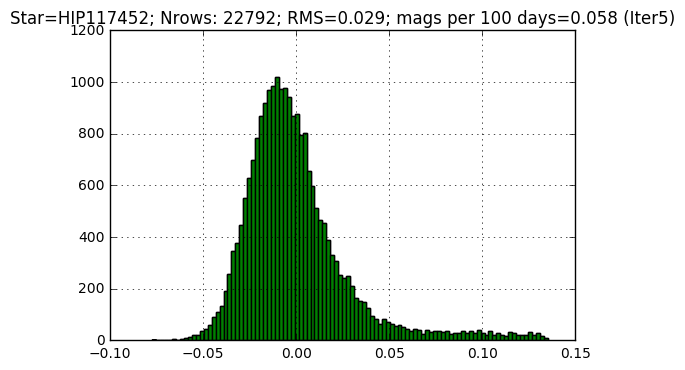

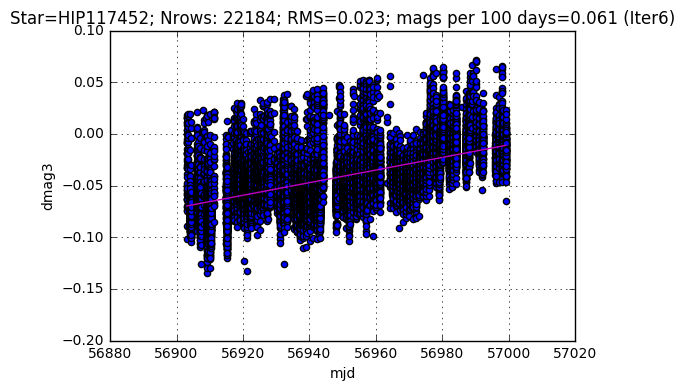

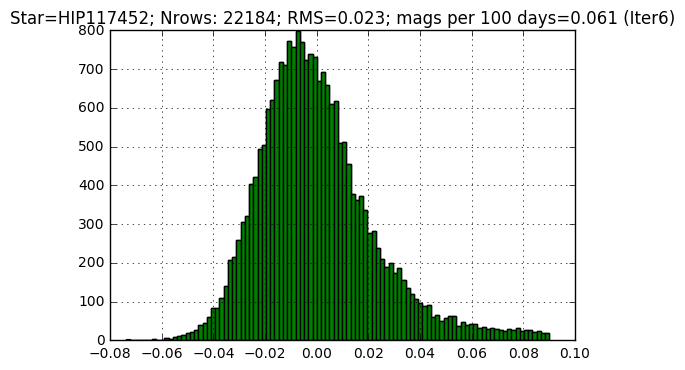

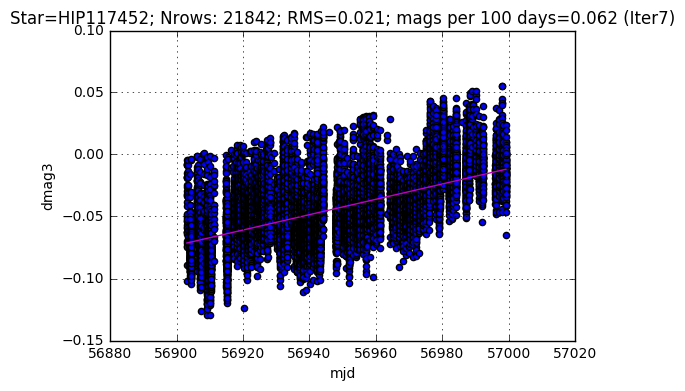

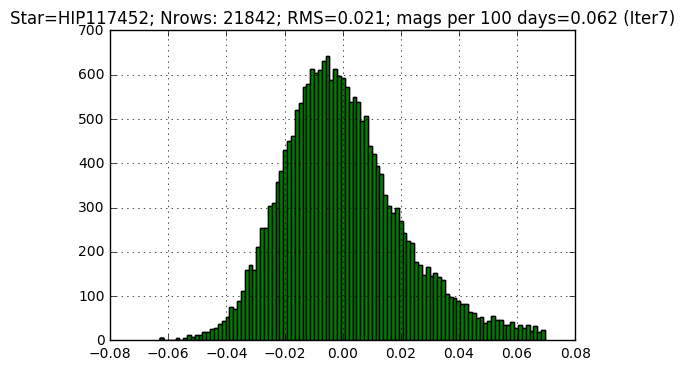

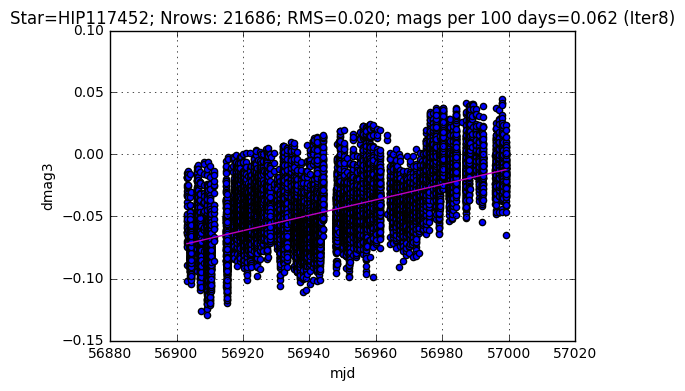

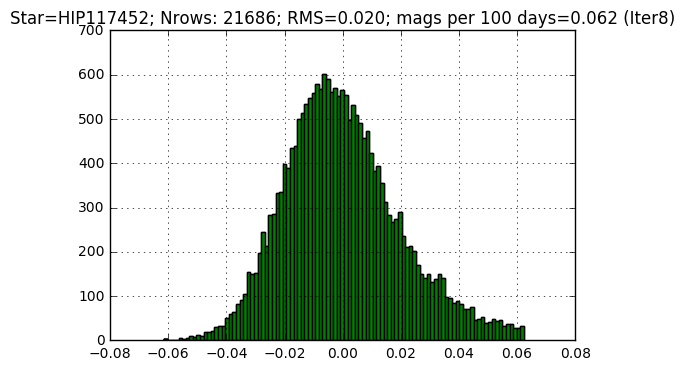

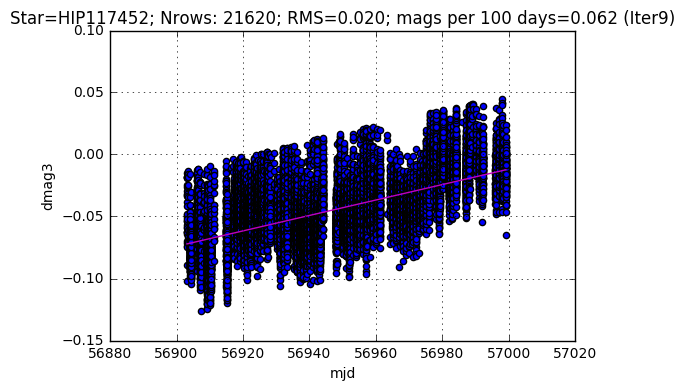

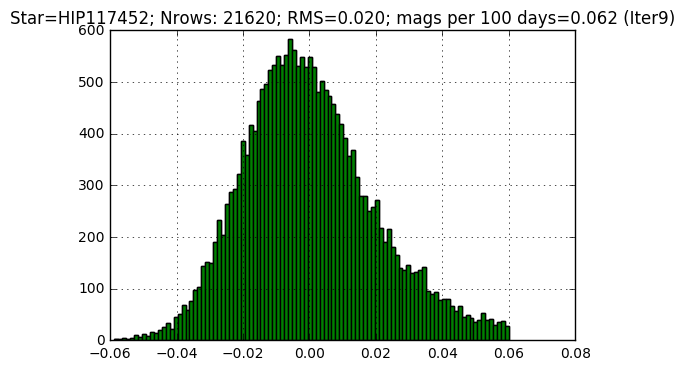

In [82]:
# Do an iterative loop to remove the additional, noticeably cloudy exposures...
niter = 9
nsigma = 3.0
for i in range(niter):

    iiter = i + 1
    print """   iter%d...""" % ( iiter )

    # make a copy of original df, overwriting the old one...
    df = df[mask].copy()

    # Fit a straight line to dmag3 vs. mjd...
    z = np.polyfit(x=df.loc[:, 'mjd'], y=df.loc[:, 'dmag3'], deg=1)
    p = np.poly1d(z)

    # How many mags of extinction due to dust accumulating on the mirror occur within 100 days...
    mag_per_100_days = 100*z[0]
    
    # Calculate residuals and add them as a column in df...
    # Confirm this:
    #df.loc[:,'res'] = df.dmag3 - p(df.mjd)
    df.loc[:,'res'] = df.loc[:,'dmag3'] - p(df.mjd)
    #df.loc[:,'res'] = df.loc[:,'dmag3'] - p(df.loc[:,'mjd'])

    stddev = df['res'].std()
    mask = (np.abs(df.res)< nsigma*stddev)
    
    nrows = df['dmag3'].size
    print """  RMS:  %f\nNumber of rows remaining:  %d""" % ( stddev, nrows )
    print """  mags per 100 days:  %f""" % (mag_per_100_days)
    print 
    
    # Output plot of dmag3 vs. MJD...
    ax=df.plot('mjd','dmag3', grid=True, kind='scatter')
    plt.plot(df.mjd,p(df.mjd),'m-')
    title = """Star=%s; Nrows: %d; RMS=%.3f; mags per 100 days=%.3f (Iter%d)""" % ('HIP117452', nrows, stddev, mag_per_100_days, iiter)
    ax.set_title(title)

    # Output histogram of residuals...
    ax=df.hist('res', grid=True, bins=100)
    ax=df['res'].hist(grid=True, bins=100)
    ax.set_title('HIP117452')
    title = """Star=%s; Nrows: %d; RMS=%.3f; mags per 100 days=%.3f (Iter%d)""" % ('HIP117452', nrows, stddev, mag_per_100_days, iiter)
    ax.set_title(title)

#endloop

** Good question:  what is a good quantitative way of knowing when to stop iterating??? 
(Especially if we don't know the random errors per observation very well in advance, making use of a chi-square check problematic.)**

In [83]:
# We don't need the 'vigintile' column anymore, so let's drop it...
df.drop('vigintile', axis=1, inplace=True)

# Add a dmjd column to df...
df.loc[:,'dmjd'] = df.loc[:,'mjd'] - df.mjd.min()

# Save a cleaned copy of the original data....
df_orig_clean = df.copy()

In [84]:
# Define some functions for fitting dmag vs. (dmjd,airmass) for mag1, mag2, and mag3...
#
# These functions are based on a scripts found at 
# http://linuxgazette.net/115/andreasen.html (by Anders Andreasen)
# and at
# http://www.phy.uct.ac.za/courses/python/examples/fitresonance.py (University of Cape Town)

# Parametric function:  
#  p is the parameter vector; 
def fp(p,dmjd_array,airmass_array):
    return p[0] + p[1]*dmjd_array + p[2]*airmass_array

# Error function:
def residuals(p,dmjd_array,airmass_array,dmag_array):
    err = (dmag_array-fp(p,dmjd_array,airmass_array))
    return err

# Fitting code:
def aTmCamTestFit(dmjd_array, airmass_array, dmag_array):

    # Calculate the median of dmag for use as an initial guess
    # for the overall zeropoint offset..
    mdn = np.median( dmag_array, None )

    # Parameter names
    pname = (['a_0', 'a_1', 'k'])

    # Initial parameter values
    p0 = [mdn, 0.0, 0.0]

    print 
    print 'Initial parameter values:  ', p0

    #print fp(p0,dmjd_array,airmass_array)
    #print residuals(p0,dmjd_array,airmass_array,dmag_array)

    # Perform fit

    p,cov,infodict,mesg,ier = leastsq(residuals, p0, args=(dmjd_array, airmass_array, dmag_array), maxfev=10000, full_output=1)

    if ( ier>=1 and ier <=4):
        print "Converged"
    else:
        print "Not converged"
        print mesg


    # Calculate some descriptors of the fit 
    # (similar to the output from gnuplot 2d fits)

    chisq=sum(infodict['fvec']*infodict['fvec'])
    dof=len(dmag_array)-len(p)
    rms=math.sqrt(chisq/dof)
    
    print "Converged with chi squared ",chisq
    print "degrees of freedom, dof ", dof
    print "RMS of residuals (i.e. sqrt(chisq/dof)) ", rms
    print "Reduced chisq (i.e. variance of residuals) ", chisq/dof
    print


    # uncertainties are calculated as per gnuplot, "fixing" the result
    # for non unit values of the reduced chisq.
    # values at min match gnuplot
    print "Fitted parameters at minimum, with 68% C.I.:"
    for i,pmin in enumerate(p):
        print "%-10s %13g +/- %13g   (%5f percent)" % (pname[i],pmin,math.sqrt(cov[i,i])*math.sqrt(chisq/dof),100.*math.sqrt(cov[i,i])*math.sqrt(chisq/dof)/abs(pmin))
    print


    print "Correlation matrix:"
    # correlation matrix close to gnuplot
    print "               ",
    for i in range(len(pname)): print "%-10s" % (pname[i],),
    print
    for i in range(len(p)):
        print "%-10s" % pname[i],
        for j in range(i+1):
	    print "%10f" % (cov[i,j]/math.sqrt(cov[i,i]*cov[j,j]),),
        #endfor
        print
    #endfor

    print
    print
    print
    
    return p, rms

In [85]:
# Create a list of the types of dmags...
dmaglist = ['dmag1', 'dmag2', 'dmag3', 'dmag4']

dmag1
   iter1...

Initial parameter values:   [-0.086600000000000676, 0.0, 0.0]
Converged
Converged with chi squared  1362.35403024
degrees of freedom, dof  21617
RMS of residuals (i.e. sqrt(chisq/dof))  0.25104251617
Reduced chisq (i.e. variance of residuals)  0.0630223449249

Fitted parameters at minimum, with 68% C.I.:
a_0            -0.460038 +/-    0.00727004   (1.580314 percent)
a_1          0.000145898 +/-   6.95957e-05   (47.701558 percent)
k               0.331062 +/-    0.00467018   (1.410669 percent)

Correlation matrix:
                a_0        a_1        k         
a_0          1.000000
a_1         -0.509350   1.000000
k           -0.881309   0.115803   1.000000



   iter2...

Initial parameter values:   [-0.087199999999999278, 0.0, 0.0]
Converged
Converged with chi squared  12.4448682569
degrees of freedom, dof  21493
RMS of residuals (i.e. sqrt(chisq/dof))  0.024062826096
Reduced chisq (i.e. variance of residuals)  0.000579019599727

Fitted parameters at minimum, wit

/Users/dtucker/anaconda2/envs/astroconda/lib/python2.7/site-packages/matplotlib/pyplot.py:516: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


   iter2...

Initial parameter values:   [-0.048000000000001819, 0.0, 0.0]
Converged
Converged with chi squared  6.46478296943
degrees of freedom, dof  21465
RMS of residuals (i.e. sqrt(chisq/dof))  0.0173544769304
Reduced chisq (i.e. variance of residuals)  0.000301177869529

Fitted parameters at minimum, with 68% C.I.:
a_0             -0.10382 +/-   0.000504787   (0.486216 percent)
a_1          0.000663003 +/-   4.82879e-06   (0.728321 percent)
k              0.0228012 +/-   0.000324016   (1.421049 percent)

Correlation matrix:
                a_0        a_1        k         
a_0          1.000000
a_1         -0.509693   1.000000
k           -0.881425   0.116356   1.000000



   iter3...

Initial parameter values:   [-0.048100000000001586, 0.0, 0.0]
Converged
Converged with chi squared  6.32606874737
degrees of freedom, dof  21416
RMS of residuals (i.e. sqrt(chisq/dof))  0.0171869088819
Reduced chisq (i.e. variance of residuals)  0.000295389836915

Fitted parameters at minimum, with 

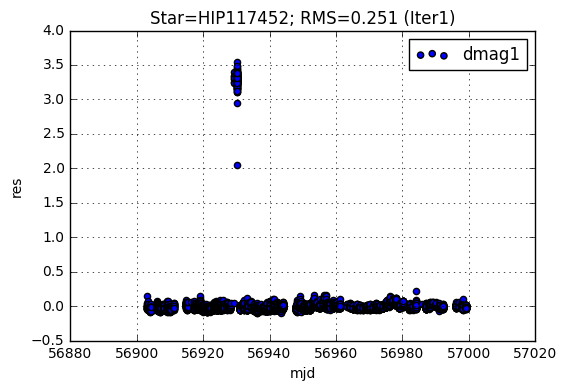

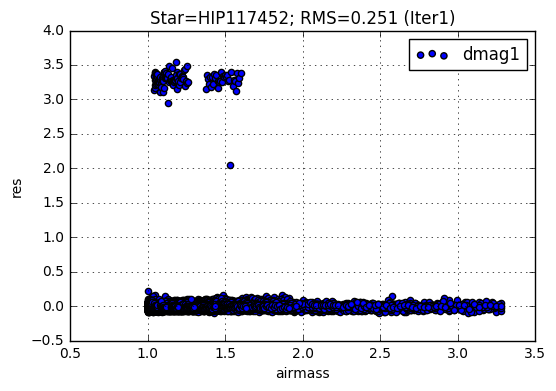

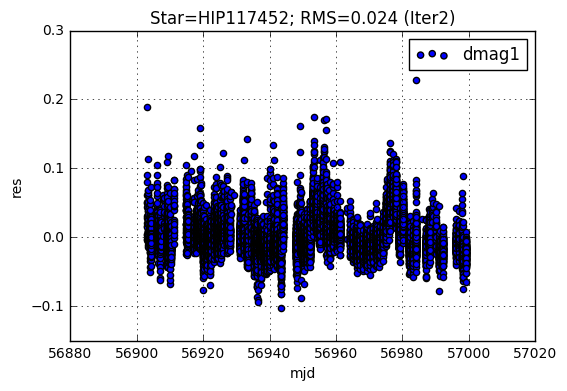

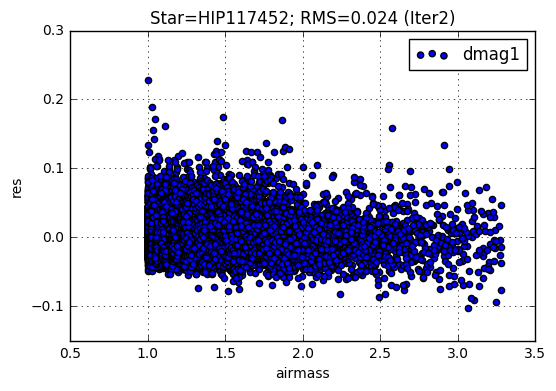

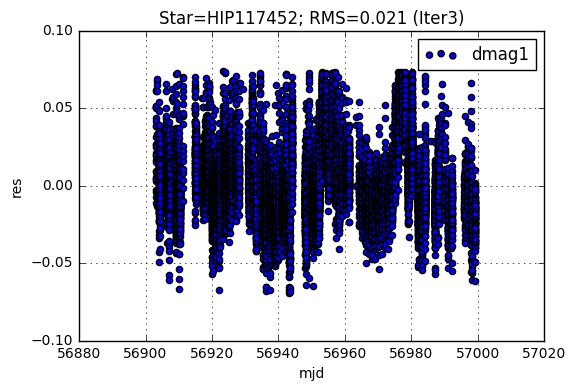

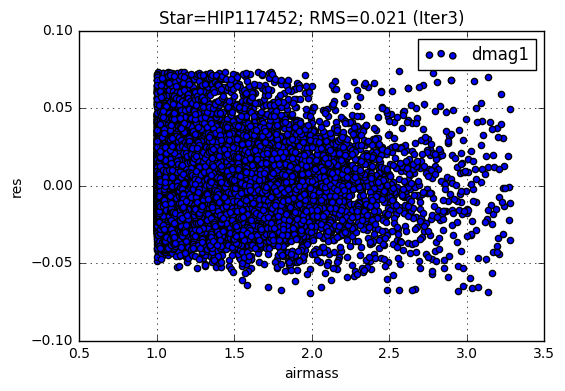

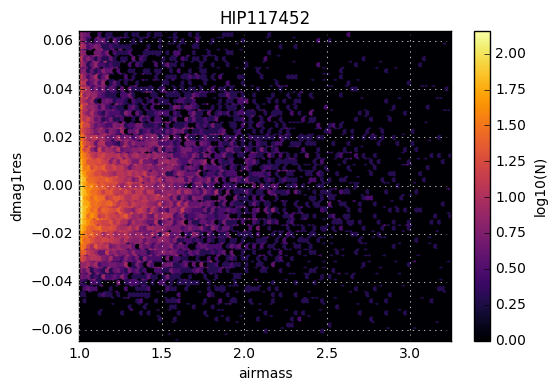

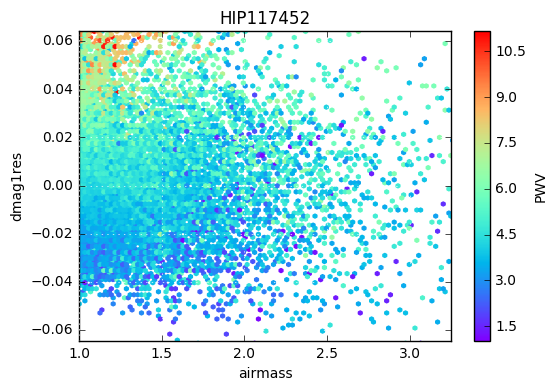

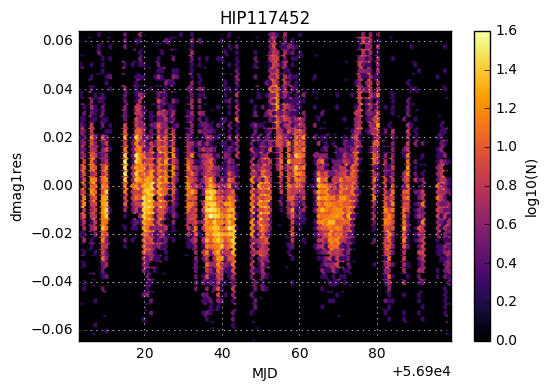

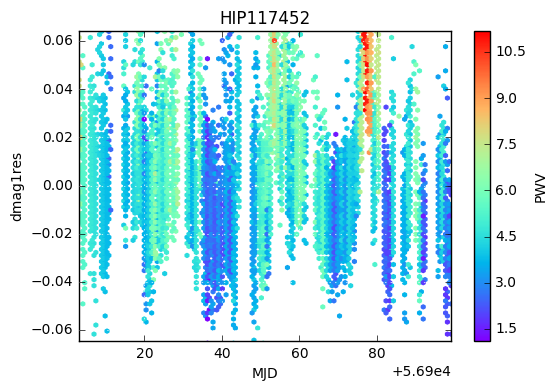

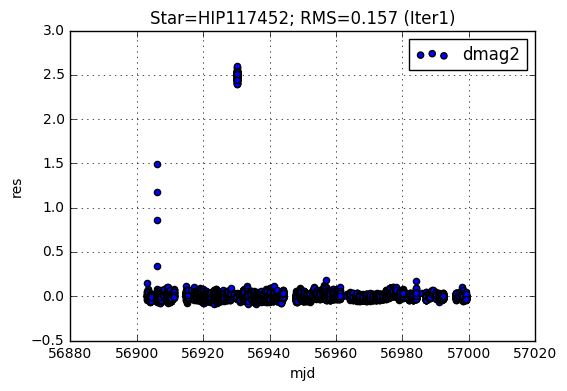

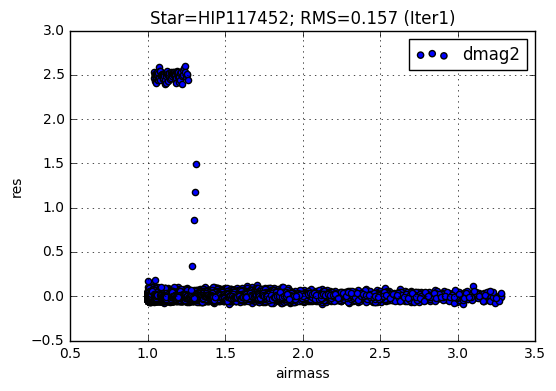

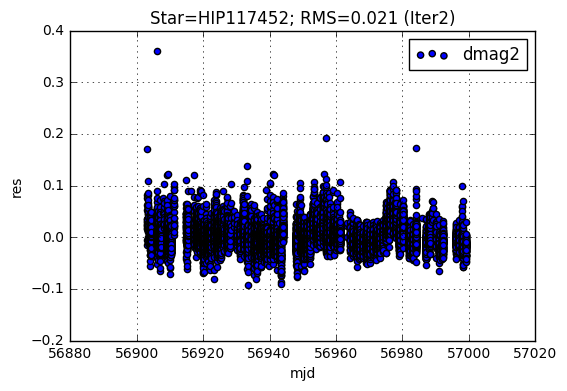

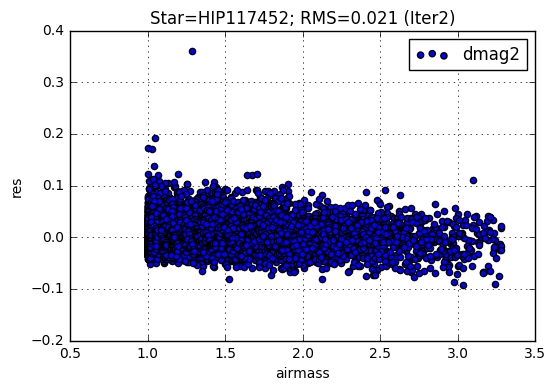

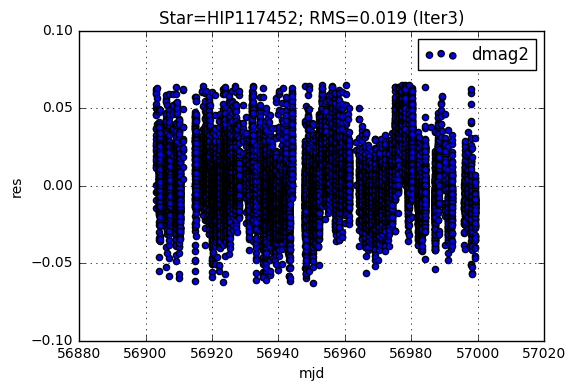

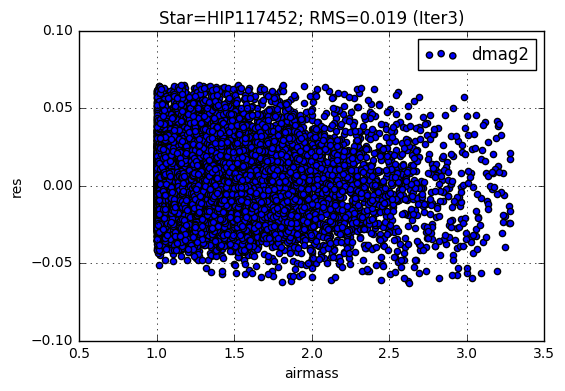

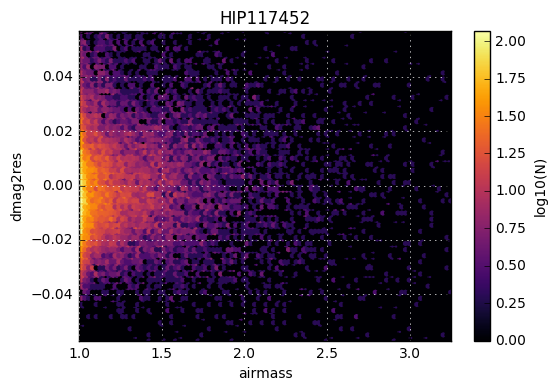

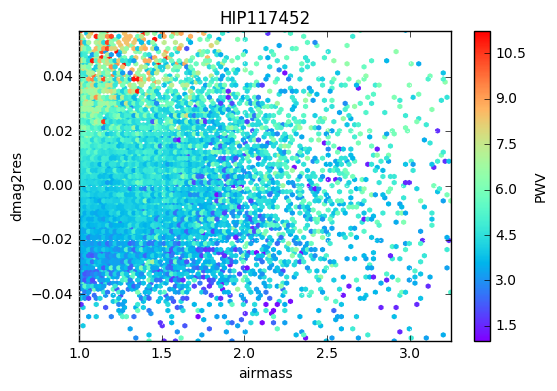

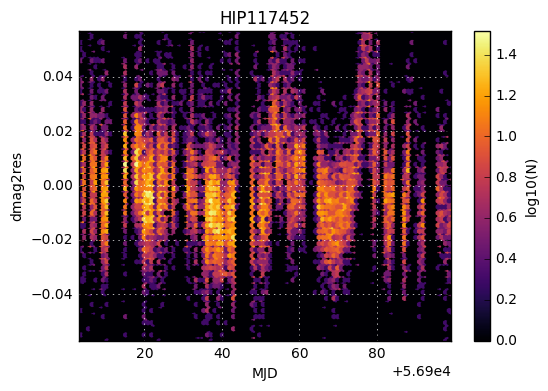

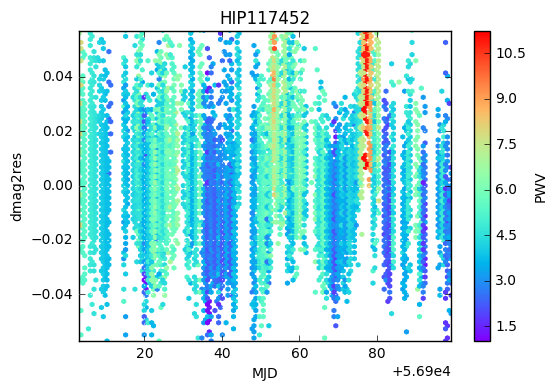

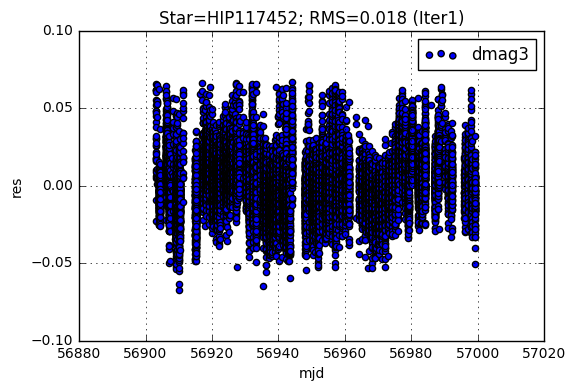

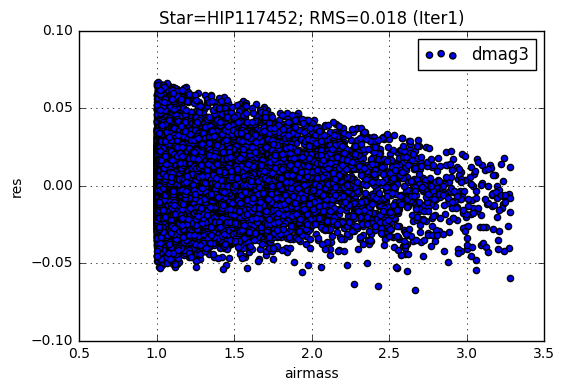

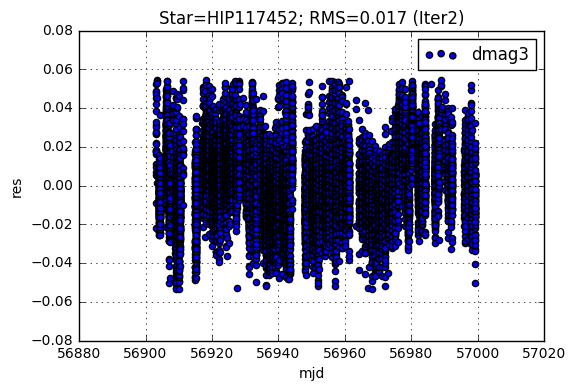

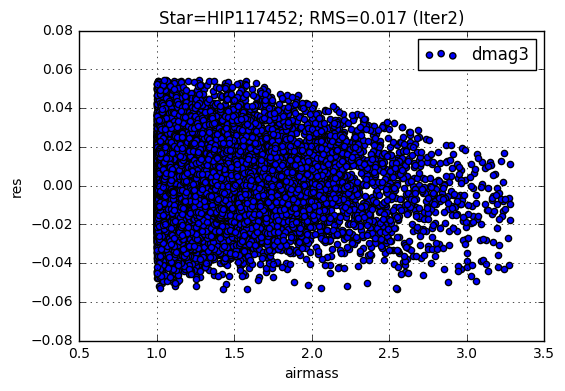

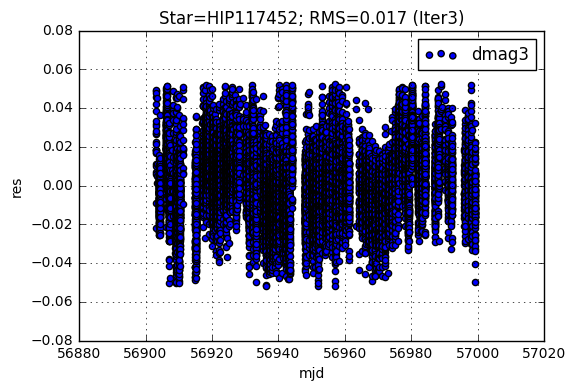

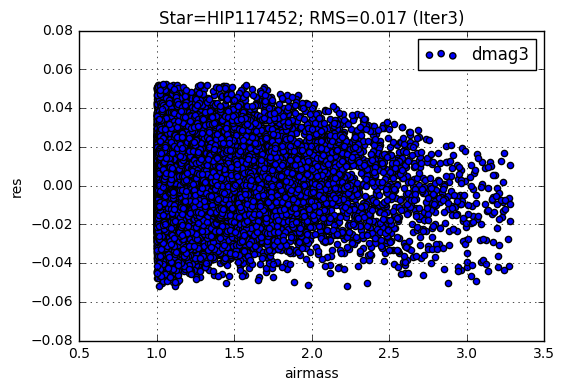

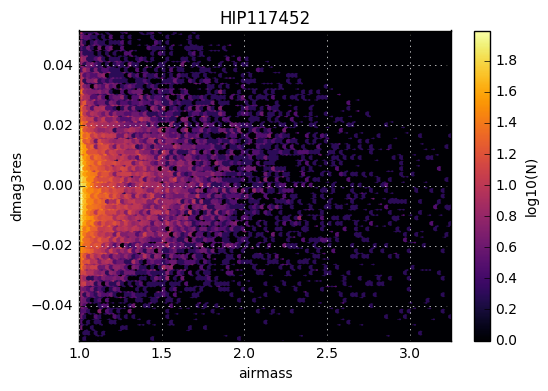

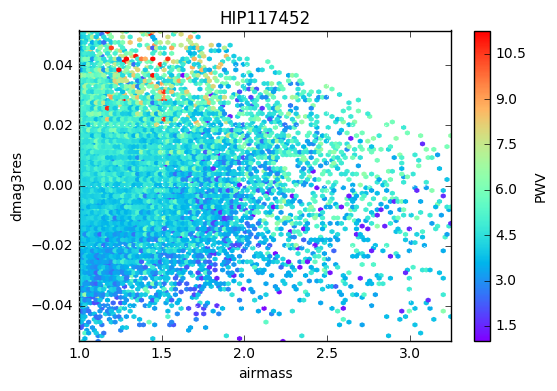

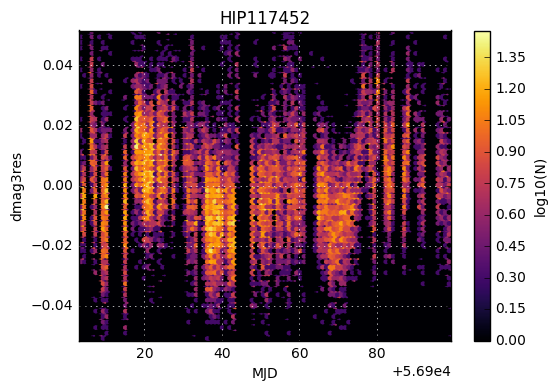

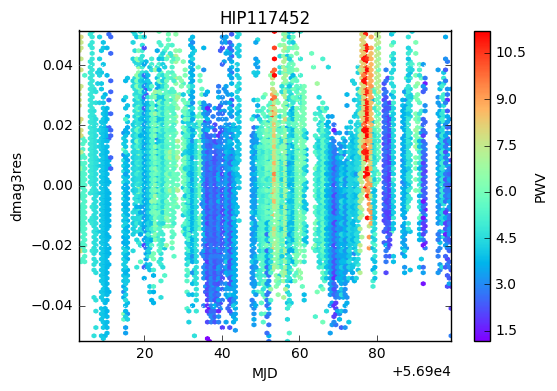

In [86]:
# Now that the obviously cloudy/bad exposures have been removed, let's do a fit of dmag vs. (dmjd,airmass)

for dmag in dmaglist:

    # We need to do something special for dmag4, so skip it for now...
    if dmag=='dmag4': continue

    print dmag

    df = df_orig_clean.copy()
        
    # Create initial (and generous)  mask...
    mask = ( df['airmass'] < 10.0 )

    # Sigma-clipping parameters...
    nsigma = 3.0
    niter = 3

    for i in range(niter):

        iiter = i + 1
        print """   iter%d...""" % ( iiter )

        # make a copy of original df, overwritting the old one...
        df = df[mask].copy()

        p,rms = aTmCamTestFit(df.loc[:,'dmjd'], df.loc[:,'airmass'], df.loc[:,dmag])
        df.loc[:,'res'] = residuals(p,df.loc[:,'dmjd'],df.loc[:,'airmass'],df.loc[:,dmag])

        stddev = df['res'].std()
        mask = (np.abs(df.res)< nsigma*stddev)
    
        # Output plot of resdiduals vs. MJD...
        ax=df.plot('mjd','res', grid=True, kind='scatter')
        #plt.plot(df.mjd,p(df.mjd),'m-')
        title = """Star=%s; RMS=%.3f (Iter%d)""" % ('HIP117452', stddev, iiter)
        ax.set_title(title)
        ax.legend(labels=[dmag])
    
        # Output plot of resdiduals vs. airmass...
        ax=df.plot('airmass','res', grid=True, kind='scatter')
        #plt.plot(df.mjd,p(df.mjd),'m-')
        title = """Star=%s; RMS=%.3f (Iter%d)""" % ('HIP117452', stddev, iiter)
        ax.set_title(title)
        ax.legend(labels=[dmag])

        # Currently having some problem with the histogram plot interacting with the other two plots...
        ## Output histogram of residuals...
        #ax=df['res'].hist(grid=True, bins=100)
        #title = """Star=%s; RMS=%.3f (Iter%d)""" % ('HIP117452', stddev, iiter)
        #ax.set_title(title)
        #ax.legend(labels=[dmag])

    #endfor
            
    # Let's plot a 2D histogram of log(Nobs), binned by dmagres and airmass, for HIP117452...
    x=df['airmass']
    y=df['res']
    xmin = 1.0
    xmax = 3.25
    ymin = -3.0*df.res.std()
    ymax =  3.0*df.res.std()
    fig, axs = plt.subplots(ncols=1)
    ax=axs
    hb = ax.hexbin(x, y, gridsize=100, bins='log', cmap='inferno')
    ax.axis([xmin, xmax, ymin, ymax])
    ax.set_title("HIP117452")
    ax.set_xlabel("airmass")
    ylabel="""%sres"""  % (dmag)
    ax.set_ylabel(ylabel)
    cb = fig.colorbar(hb, ax=ax)
    cb.set_label('log10(N)')
    plt.grid(True)
    ax.grid(color='white')
        
    # Let's plot a 2D histogram of PWV, binned by dmagres and airmass, for HIP117452...
    x=df['airmass']
    y=df['res']
    z=df['pwv']
    xmin = 1.0
    xmax = 3.25
    ymin = -3.0*df.res.std()
    ymax =  3.0*df.res.std()
    fig, axs = plt.subplots(ncols=1)
    ax=axs
    hb = ax.hexbin(x, y, C=z, gridsize=100, cmap='rainbow', reduce_C_function=np.median)
    ax.axis([xmin, xmax, ymin, ymax])
    ax.set_title("HIP117452")
    ax.set_xlabel("airmass")
    ylabel="""%sres"""  % (dmag)
    ax.set_ylabel(ylabel)
    cb = fig.colorbar(hb, ax=ax)
    cb.set_label('PWV')
    plt.grid(True)
    ax.grid(color='white')

    # Let's plot a 2D histogram of log(Nobs), binned by dmagres and mjd, for HIP117452...
    x=df['mjd']
    y=df['res']
    xmin = df.mjd.min()
    xmax = df.mjd.max()
    ymin = -3.0*df.res.std()
    ymax =  3.0*df.res.std()
    fig, axs = plt.subplots(ncols=1)
    ax=axs
    hb = ax.hexbin(x, y, gridsize=100, bins='log', cmap='inferno')
    ax.axis([xmin, xmax, ymin, ymax])
    ax.set_title("HIP117452")
    ax.set_xlabel("MJD")
    ylabel="""%sres"""  % (dmag)
    ax.set_ylabel(ylabel)
    cb = fig.colorbar(hb, ax=ax)
    cb.set_label('log10(N)')
    plt.grid(True)
    ax.grid(color='white')
    
    # Let's plot a 2D histogram of PWV, binned by dmagres and mjd, for HIP117452...
    x=df['mjd']
    y=df['res']
    z=df['pwv']
    xmin = df.mjd.min()
    xmax = df.mjd.max()
    ymin = -3.0*df.res.std()
    ymax =  3.0*df.res.std()
    fig, axs = plt.subplots(ncols=1)
    ax=axs
    hb = ax.hexbin(x, y, C=z, gridsize=100, cmap='rainbow', reduce_C_function=np.median)
    ax.axis([xmin, xmax, ymin, ymax])
    ax.set_title("HIP117452")
    ax.set_xlabel("MJD")
    ylabel="""%sres"""  % (dmag)
    ax.set_ylabel(ylabel)
    cb = fig.colorbar(hb, ax=ax)
    cb.set_label('PWV')
    plt.grid(True)
    ax.grid(color='white')

    
#endfor

**For mag1, mag2, and mag3, assuming a strictly linear degradation of system throughput over time due to dust accumulation on the lenses between lens cleanings seems reasonable.  Also, assuming a single, "site-average" airmass-dependent extinction is not a bad approximation, yielding fits with RMS's of less than 0.02mag.  There _are_, however, trends in the residuals vs. time, and these seem to be well-correlated among these three aTmCam filter bands.  It might be worthwhile fitting a separate airmass-dependent extinction term per night for each of the aTmCam filter bands (although it would be interesting, since the variations appear to be correlated to be able to combine all 3 mags to fit out this time-dependent trend).**

** Since mag4 depends on both airmass and PWV (and more strongly on PWV), we need another set of functions to deal with the mag4 fits...**

In [87]:
# Define some functions for fitting dmag vs. (dmjd,airmass,PWV) for mag4...
#
# These functions are based on a scripts found at 
# http://linuxgazette.net/115/andreasen.html (by Anders Andreasen)
# and at
# http://www.phy.uct.ac.za/courses/python/examples/fitresonance.py (University of Cape Town)

# Parametric function:  
#  p is the parameter vector; 
def fp4(p,dmjd_array,airmass_array,pwv_array):
    # Following Ting's suggestion, we the airmass is raised to the 0.6 power...
    return p[0] + p[1]*dmjd_array + p[2]*np.power(airmass_array,0.6) + p[3]*pwv_array

#--------------------------------------------------------------------------
# Error function:
def residuals4(p,dmjd_array,airmass_array,pwv_array,dmag_array):
    err = (dmag_array-fp4(p,dmjd_array,airmass_array,pwv_array))
    return err

#--------------------------------------------------------------------------
# Fitting code:
def aTmCamTestFit4(dmjd_array, airmass_array, pwv_array, dmag_array):

    # Calculate the median of dmag for use as an initial guess
    # for the overall zeropoint offset..
    mdn = np.median( dmag_array, None )

    # Parameter names
    pname = (['a_0', 'a_1', 'k_airmass', 'k_pwv'])

    # Initial parameter values
    p0 = [mdn, 0.0, 0.0, 0.0]

    print 
    print 'Initial parameter values:  ', p0

    #print fp4(p0,dmjd_array,airmass_array,pwv_array)
    #print residuals4(p0,dmjd_array,airmass_array,pwv_array,dmag_array)

    # Perform fit

    p,cov,infodict,mesg,ier = leastsq(residuals4, p0, args=(dmjd_array, airmass_array, pwv_array, dmag_array), maxfev=10000, full_output=1)

    if ( ier>=1 and ier <=4):
        print "Converged"
    else:
        print "Not converged"
        print mesg


    # Calculate some descriptors of the fit 
    # (similar to the output from gnuplot 2d fits)

    chisq=sum(infodict['fvec']*infodict['fvec'])
    dof=len(dmag_array)-len(p)
    rms=math.sqrt(chisq/dof)
    
    print "Converged with chi squared ",chisq
    print "degrees of freedom, dof ", dof
    print "RMS of residuals (i.e. sqrt(chisq/dof)) ", rms
    print "Reduced chisq (i.e. variance of residuals) ", chisq/dof
    print


    # uncertainties are calculated as per gnuplot, "fixing" the result
    # for non unit values of the reduced chisq.
    # values at min match gnuplot
    print "Fitted parameters at minimum, with 68% C.I.:"
    for i,pmin in enumerate(p):
        print "%-10s %13g +/- %13g   (%5f percent)" % (pname[i],pmin,math.sqrt(cov[i,i])*math.sqrt(chisq/dof),100.*math.sqrt(cov[i,i])*math.sqrt(chisq/dof)/abs(pmin))
    print


    print "Correlation matrix:"
    # correlation matrix close to gnuplot
    print "               ",
    for i in range(len(pname)): print "%-10s" % (pname[i],),
    print
    for i in range(len(p)):
        print "%-10s" % pname[i],
        for j in range(i+1):
	    print "%10f" % (cov[i,j]/math.sqrt(cov[i,i]*cov[j,j]),),
        #endfor
        print
    #endfor

    print
    print
    print
    
    return p, rms

In [88]:
# Now we work on dmag4...
dmag = 'dmag4'
print dmag

df = df_orig_clean.copy()
        
# Create initial (and generous)  mask, ESPECIALLY FOR mag4...
mask = ( ( df['airmass'] < 10.0 ) & ( df['pwv'] < 8.0 ) )

dmag4


   iter1...

Initial parameter values:   [-0.064600000000002211, 0.0, 0.0, 0.0]
Converged
Converged with chi squared  92.7958427669
degrees of freedom, dof  21130
RMS of residuals (i.e. sqrt(chisq/dof))  0.066269624786
Reduced chisq (i.e. variance of residuals)  0.00439166316928

Fitted parameters at minimum, with 68% C.I.:
a_0            -0.781192 +/-    0.00351017   (0.449335 percent)
a_1          0.000394141 +/-   1.87037e-05   (4.745437 percent)
k_airmass       0.365261 +/-    0.00248109   (0.679264 percent)
k_pwv           0.065165 +/-   0.000345685   (0.530477 percent)

Correlation matrix:
                a_0        a_1        k_airmass  k_pwv     
a_0          1.000000
a_1         -0.354353   1.000000
k_airmass   -0.858551   0.112802   1.000000
k_pwv       -0.467857   0.083078   0.029938   1.000000



   iter2...

Initial parameter values:   [-0.063700000000000756, 0.0, 0.0, 0.0]
Converged
Converged with chi squared  69.2009895768
degrees of freedom, dof  20908
RMS of residuals 

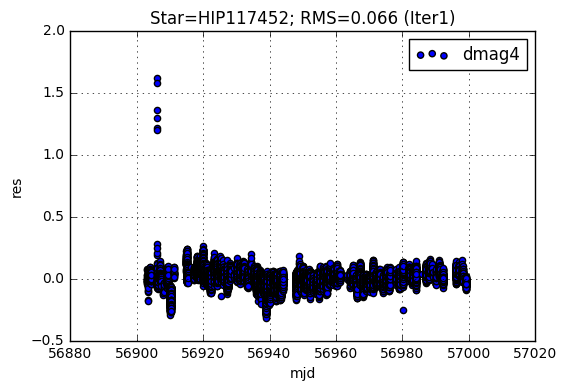

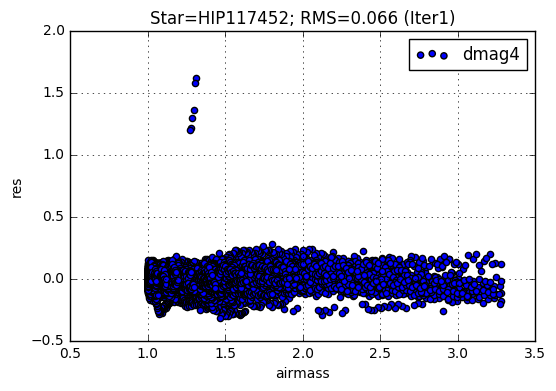

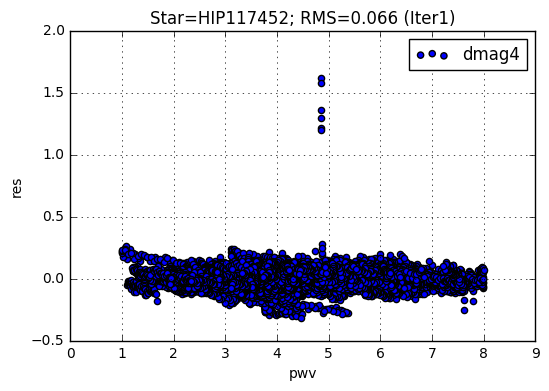

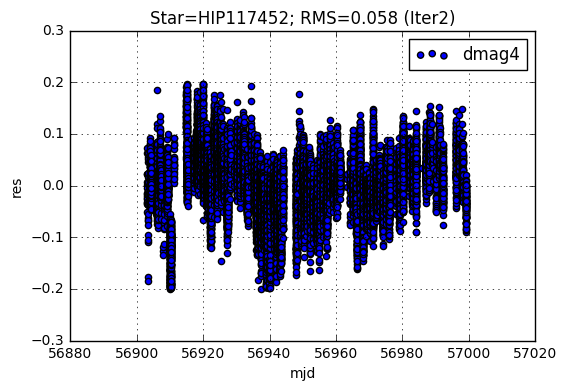

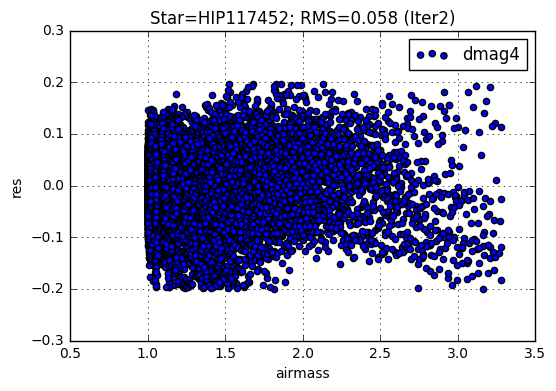

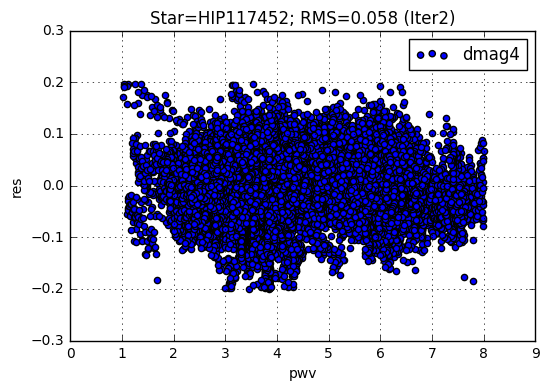

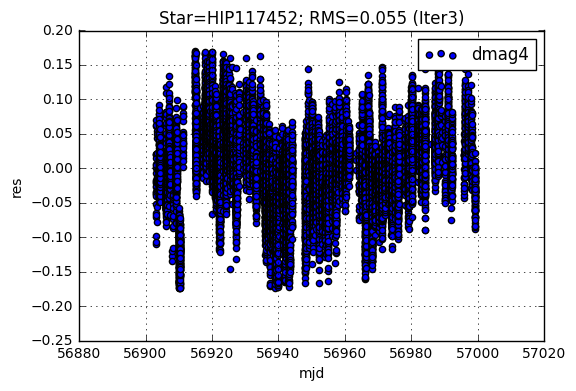

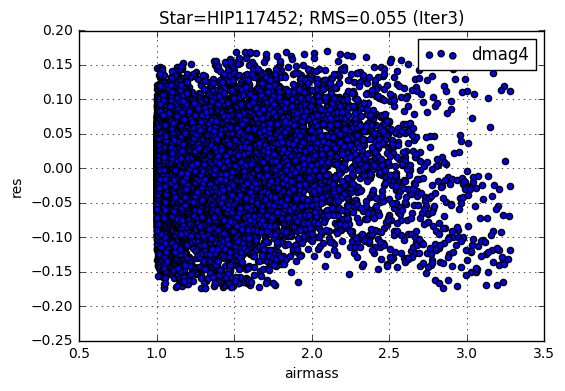

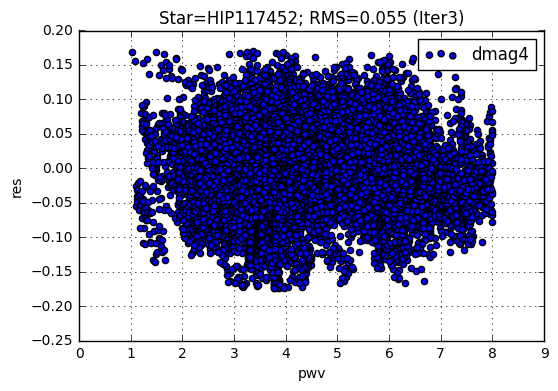

In [89]:
# Sigma-clipping parameters...
nsigma = 3.0
niter = 3

for i in range(niter):

    iiter = i + 1
    print """   iter%d...""" % ( iiter )

    # make a copy of original df, overwriting the old one...
    df = df[mask].copy()

    p,rms = aTmCamTestFit4(df.loc[:,'dmjd'], df.loc[:,'airmass'], df.loc[:,'pwv'], df.loc[:,dmag])
    df.loc[:,'res'] = residuals4(p,df.loc[:,'dmjd'],df.loc[:,'airmass'],df.loc[:,'pwv'],df.loc[:,dmag])

    stddev = df['res'].std()
    mask = (np.abs(df.res)< nsigma*stddev)
    
    # Output plot of resdiduals vs. MJD...
    ax=df.plot('mjd','res', grid=True, kind='scatter')
    #plt.plot(df.mjd,p(df.mjd),'m-')
    title = """Star=%s; RMS=%.3f (Iter%d)""" % ('HIP117452', stddev, iiter)
    ax.set_title(title)
    ax.legend(labels=[dmag])

    # Output plot of resdiduals vs. airmass...
    ax=df.plot('airmass','res', grid=True, kind='scatter')
    #plt.plot(df.mjd,p(df.mjd),'m-')
    title = """Star=%s; RMS=%.3f (Iter%d)""" % ('HIP117452', stddev, iiter)
    ax.set_title(title)
    ax.legend(labels=[dmag])

    # Output plot of resdiduals vs. PWV...
    ax=df.plot('pwv','res', grid=True, kind='scatter')
    #plt.plot(df.mjd,p(df.mjd),'m-')
    title = """Star=%s; RMS=%.3f (Iter%d)""" % ('HIP117452', stddev, iiter)
    ax.set_title(title)
    ax.legend(labels=[dmag])

    # Currently having some problem with the histogram plot interacting with the other two plots...
    ## Output histogram of residuals...
    #ax=df['res'].hist(grid=True, bins=100)
    #title = """Star=%s; RMS=%.3f (Iter%d)""" % ('HIP117452', stddev, iiter)
    #ax.set_title(title)
    #ax.legend(labels=[dmag])

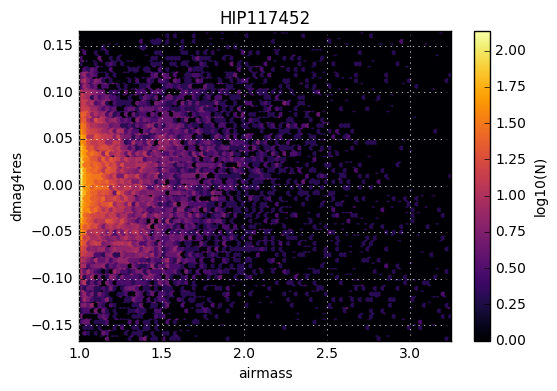

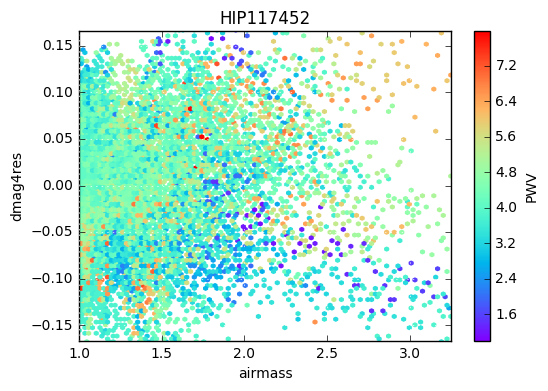

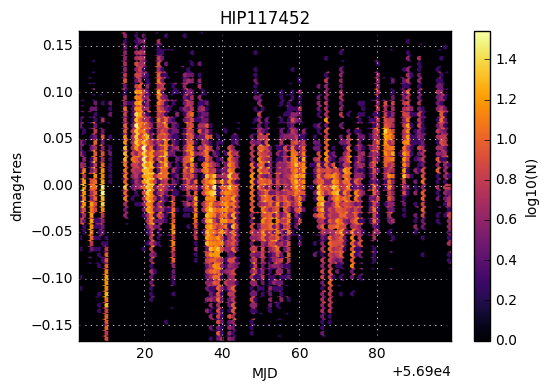

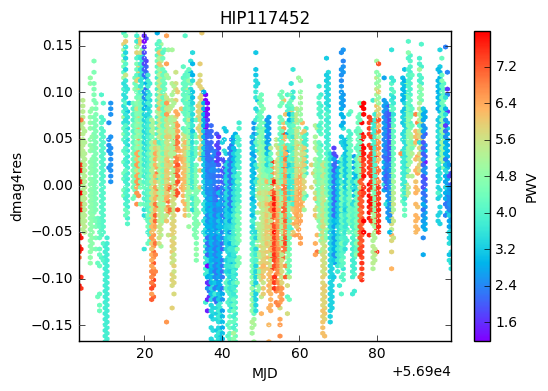

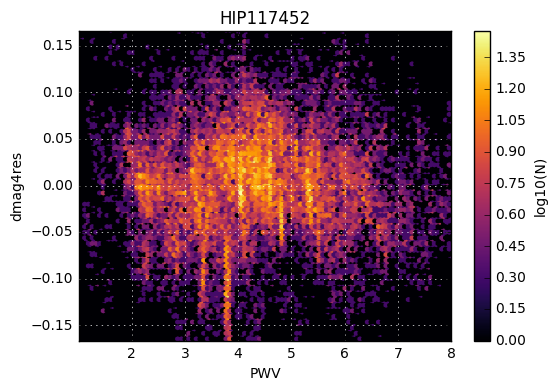

In [90]:
# Let's plot a 2D histogram of log(Nobs), binned by dmagres and airmass, for HIP117452...
x=df['airmass']
y=df['res']
xmin = 1.0
xmax = 3.25
ymin = -3.0*df.res.std()
ymax =  3.0*df.res.std()
fig, axs = plt.subplots(ncols=1)
ax=axs
hb = ax.hexbin(x, y, gridsize=100, bins='log', cmap='inferno')
ax.axis([xmin, xmax, ymin, ymax])
ax.set_title("HIP117452")
ax.set_xlabel("airmass")
ylabel="""%sres"""  % (dmag)
ax.set_ylabel(ylabel)
cb = fig.colorbar(hb, ax=ax)
cb.set_label('log10(N)')
plt.grid(True)
ax.grid(color='white')

# Let's plot a 2D histogram of PWV, binned by dmagres and airmass, for HIP117452...
x=df['airmass']
y=df['res']
z=df['pwv']
xmin = 1.0
xmax = 3.25
ymin = -3.0*df.res.std()
ymax =  3.0*df.res.std()
fig, axs = plt.subplots(ncols=1)
ax=axs
hb = ax.hexbin(x, y, C=z, gridsize=100, cmap='rainbow', reduce_C_function=np.median)
ax.axis([xmin, xmax, ymin, ymax])
ax.set_title("HIP117452")
ax.set_xlabel("airmass")
ylabel="""%sres"""  % (dmag)
ax.set_ylabel(ylabel)
cb = fig.colorbar(hb, ax=ax)
cb.set_label('PWV')
plt.grid(True)
ax.grid(color='white')

# Let's plot a 2D histogram of log(Nobs), binned by dmagres and mjd, for HIP117452...
x=df['mjd']
y=df['res']
xmin = df.mjd.min()
xmax = df.mjd.max()
ymin = -3.0*df.res.std()
ymax =  3.0*df.res.std()
fig, axs = plt.subplots(ncols=1)
ax=axs
hb = ax.hexbin(x, y, gridsize=100, bins='log', cmap='inferno')
ax.axis([xmin, xmax, ymin, ymax])
ax.set_title("HIP117452")
ax.set_xlabel("MJD")
ylabel="""%sres"""  % (dmag)
ax.set_ylabel(ylabel)
cb = fig.colorbar(hb, ax=ax)
cb.set_label('log10(N)')
plt.grid(True)
ax.grid(color='white')
    
# Let's plot a 2D histogram of PWV, binned by dmagres and mjd, for HIP117452...
x=df['mjd']
y=df['res']
z=df['pwv']
xmin = df.mjd.min()
xmax = df.mjd.max()
ymin = -3.0*df.res.std()
ymax =  3.0*df.res.std()
fig, axs = plt.subplots(ncols=1)
ax=axs
hb = ax.hexbin(x, y, C=z, gridsize=100, cmap='rainbow', reduce_C_function=np.median)
ax.axis([xmin, xmax, ymin, ymax])
ax.set_title("HIP117452")
ax.set_xlabel("MJD")
ylabel="""%sres"""  % (dmag)
ax.set_ylabel(ylabel)
cb = fig.colorbar(hb, ax=ax)
cb.set_label('PWV')
plt.grid(True)
ax.grid(color='white')

# Let's plot a 2D histogram of log(Nobs), binned by dmagres and pwv, for HIP117452...
x=df['pwv']
y=df['res']
xmin = df.pwv.min()
xmax = df.pwv.max()
ymin = -3.0*df.res.std()
ymax =  3.0*df.res.std()
fig, axs = plt.subplots(ncols=1)
ax=axs
hb = ax.hexbin(x, y, gridsize=100, bins='log', cmap='inferno')
ax.axis([xmin, xmax, ymin, ymax])
ax.set_title("HIP117452")
ax.set_xlabel("PWV")
ylabel="""%sres"""  % (dmag)
ax.set_ylabel(ylabel)
cb = fig.colorbar(hb, ax=ax)
cb.set_label('log10(N)')
plt.grid(True)
ax.grid(color='white')

**The residuals for mag4 are noticeably larger than for the other filter bands (c. 0.055mag RMS vs. 0.017mag RMS), and the overall trend vs. time does not appear to correlate quite so well with the mag1, mag2, and mag3 residuals.  Part of the extra noise may just be due to the fact that the S/N in mag4 tends to be noticeably smaller than the S/N for the other mags (but this is still to be checked).   From the final plot (dmag4res vs. PWV), it also appears that there may be higher order terms to be fit.  Also, as with the other filter band mags, it may be worthwhile to fit separate airmass-dependent extinction terms for each night.  We are still thinking about how best to proceed.**

***
# Sandbox

In [109]:
df = df_orig_clean.copy()
        
# Create initial (and generous)  mask...
mask = ( df['airmass'] < 10.0 )

df = df[mask].copy()
#print df.head(10)
#print df.columns
nightArray = np.sort(df.imjd.unique())
print nightArray[10]  # I think we want nightArray
nightSeries = pd.Series(nightArray)
print nightSeries[10]
print nightSeries.size
print nightArray.size
nightArr

56917
56917
84
84


***

# End Notes

* Ting noticed that, every time I do a merge, I end up with multiple duplicate rows.  This does not affect the plots (the duplicate entries just overplot each other), but it _is_ annoying.  Something to check out and fix... --> ** (22 March 2017)  Fixed!  Turned out, there were many duplicate rows in obsdf.  This has been corrected**

* **Next steps:**

1. Correlate aTmCam and GPSmon PWVs. --> ** Partly done**

2. Remove effects of changing aTmCam throughput. --> ** Done **

3. Perform a relative calibration of the different observed stars so that all the star data can be used together (also test and if necessary correct for slight differences in the colors of these A0V stars).  --> ** Not yet **

4. Compare aTmCam (mag1,mag2,mag3,mag4) first-order extinctions with DECam (u,g,r,i,z,Y) first-order extinctions. --> ** Not yet **
